# 数据处理

In [19]:
import numpy as np
import pandas as pd
import lightgbm
import shap
from lightgbm import log_evaluation, early_stopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, mean_squared_error, classification_report
from sklearn.preprocessing import LabelEncoder
from shap_plot import summary_bar_plot, summary_dot_plot, dependence_plot, waterfall_plot
import joblib
import matplotlib.pyplot as plt
import multiprocessing
from tqdm import tqdm

In [20]:
def flatten(group):
    return pd.Series(group.values.flatten())

In [21]:
def data_load(path):
    df = pd.read_csv(path, index_col=0)
    df = df.groupby('room_id').filter(lambda x: len(x) == 6)
    df = df.sort_values(by=["room_id", 'home_team'], ascending=(True, False))
    return df

In [22]:
def data_preprocess(df):
    df_flatten = df.groupby('room_id').apply(flatten)
    feature_names = ['room_id', 'role_id', 'home_team', 'result', 'bestrongdisturbedshoot', 'nicepass', 'buffultraskillsteal',
        'twoshots', 'buffultraskillrebound', 'block', 'twopointsgoalin', 'threepointsgoalin', 'disturbedlayupnum', 'beblockedthreepointsshoot', 'threepointsshoot',
        'ultraskill', 'benicepass', 'allmorale', 'beblockedtwolayup', 'blocktwoshots', 'bedisturbedtwoshotsnum', 'skillintercept',
        'bedisturbedthreepointsshootsnum', 'bedisturbedlayupnum', 'pickandrollnum', 'pickandrollsuccessnum', 'feintshoot',
        'pickandrolldownnum', 'boxoutsuccessnum', 'rebound', 'offenceovertime', 'beblockedultraskill', 'bignointerthreeshoot',
        'boxoutpushnum', 'crossoverloseball', 'shakedown', 'ballownertimeproportion', 'irrationalshootnum', 'offensiverebound',
        'twopointsshoot', 'buffultraskillblock', 'skillfloorball', 'mvppoint', 'defencecrossover', 'bedisturbedshoot', 'assist',
        'blockultraskillmiss', 'defensiverebound', 'screensucess', 'beblocked', 'beblockedtwodunk', 'bedisturbeddunknum',
        'nointertwoshoot', 'bedisturbednum', 'sorryblocks', 'bestealed', 'blocktwodunk', 'afknum', 'nointershoot', 'stealultraskillmiss',
        'passfailed', 'buffultraskillintercept', 'disturbedtwoshotsnum', 'buffultraskilltwoshots', 'defencecrossoverdeadlose',
        'bignointertwoshoot', 'steal', 'blockultraskill', 'twobarelylayup', 'boxoutnum', 'stealultraskillhit', 'shotnodribble',
        'afktime', 'disturbedthreepointsshootsnum', 'beblockedtwoshots', 'morale', 'role_player_id',  'bignointershoot',
        'blocktwolayup', 'passiveintercept', 'disturbenemyshoot', 'nointerthreeshoot', 'buffultraskillfloorball', 'twolayup',
        'enemycrossoverloseball', 'passball', 'disturbeddunknum', 'twodunk', 'nicepassshoot', 'blockultraskillhit', 'shootproportion',
        'floorball', 'blockthreepointsshoot', 'allshoots', 'totalmovedis']
    flatten_feature_names = [feature_names[i]+'_'+str(k) for k in range(6) for i in range(len(feature_names))]
    
    df_flatten.columns = flatten_feature_names
    #V_1
    train_feature_names = ['bestrongdisturbedshoot', 'nicepass', 'buffultraskillsteal',
        'twoshots', 'buffultraskillrebound', 'block', 'disturbedlayupnum', 'beblockedthreepointsshoot', 'threepointsshoot',
        'ultraskill', 'benicepass', 'allmorale', 'beblockedtwolayup', 'blocktwoshots', 'bedisturbedtwoshotsnum', 'skillintercept',
        'bedisturbedthreepointsshootsnum', 'bedisturbedlayupnum', 'pickandrollnum', 'pickandrollsuccessnum', 'feintshoot',
        'pickandrolldownnum', 'boxoutsuccessnum', 'rebound', 'offenceovertime', 'beblockedultraskill', 'bignointerthreeshoot',
        'boxoutpushnum', 'crossoverloseball', 'shakedown', 'ballownertimeproportion', 'irrationalshootnum', 'offensiverebound',
        'twopointsshoot', 'buffultraskillblock', 'skillfloorball', 'defencecrossover', 'bedisturbedshoot', 'assist',
        'blockultraskillmiss', 'defensiverebound', 'screensucess', 'beblocked', 'beblockedtwodunk', 'bedisturbeddunknum',
        'nointertwoshoot', 'bedisturbednum', 'sorryblocks', 'bestealed', 'blocktwodunk', 'afknum', 'nointershoot', 'stealultraskillmiss',
        'passfailed', 'buffultraskillintercept', 'disturbedtwoshotsnum', 'buffultraskilltwoshots', 'defencecrossoverdeadlose',
        'bignointertwoshoot', 'steal', 'blockultraskill', 'twobarelylayup', 'boxoutnum', 'stealultraskillhit', 'shotnodribble',
        'afktime', 'disturbedthreepointsshootsnum', 'beblockedtwoshots', 'morale', 'role_player_id', 'bignointershoot',
        'blocktwolayup', 'passiveintercept', 'disturbenemyshoot', 'nointerthreeshoot', 'buffultraskillfloorball', 'twolayup',
        'enemycrossoverloseball', 'passball', 'disturbeddunknum', 'twodunk', 'nicepassshoot', 'blockultraskillhit', 'shootproportion',
        'floorball', 'blockthreepointsshoot', 'allshoots', 'totalmovedis']
    # #V_2：去除'defensiverebound'
    # train_feature_names = ['bestrongdisturbedshoot', 'nicepass', 'buffultraskillsteal',
    #     'twoshots', 'buffultraskillrebound', 'block', 'disturbedlayupnum', 'beblockedthreepointsshoot', 'threepointsshoot',
    #     'ultraskill', 'benicepass', 'allmorale', 'beblockedtwolayup', 'blocktwoshots', 'bedisturbedtwoshotsnum', 'skillintercept',
    #     'bedisturbedthreepointsshootsnum', 'bedisturbedlayupnum', 'pickandrollnum', 'pickandrollsuccessnum', 'feintshoot',
    #     'pickandrolldownnum', 'boxoutsuccessnum', 'rebound', 'offenceovertime', 'beblockedultraskill', 'bignointerthreeshoot',
    #     'boxoutpushnum', 'crossoverloseball', 'shakedown', 'ballownertimeproportion', 'irrationalshootnum', 'offensiverebound',
    #     'twopointsshoot', 'buffultraskillblock', 'skillfloorball', 'defencecrossover', 'bedisturbedshoot', 'assist',
    #     'blockultraskillmiss',  'screensucess', 'beblocked', 'beblockedtwodunk', 'bedisturbeddunknum',
    #     'nointertwoshoot', 'bedisturbednum', 'sorryblocks', 'bestealed', 'blocktwodunk', 'afknum', 'nointershoot', 'stealultraskillmiss',
    #     'passfailed', 'buffultraskillintercept', 'disturbedtwoshotsnum', 'buffultraskilltwoshots', 'defencecrossoverdeadlose',
    #     'bignointertwoshoot', 'steal', 'blockultraskill', 'twobarelylayup', 'boxoutnum', 'stealultraskillhit', 'shotnodribble',
    #     'afktime', 'disturbedthreepointsshootsnum', 'beblockedtwoshots', 'morale', 'role_player_id', 'bignointershoot',
    #     'blocktwolayup', 'passiveintercept', 'disturbenemyshoot', 'nointerthreeshoot', 'buffultraskillfloorball', 'twolayup',
    #     'enemycrossoverloseball', 'passball', 'disturbeddunknum', 'twodunk', 'nicepassshoot', 'blockultraskillhit', 'shootproportion',
    #     'floorball', 'blockthreepointsshoot', 'allshoots', 'totalmovedis']
    #V_3：去除'defensiverebound', 'allmorale',
    # train_feature_names = [ 'nicepass', 
    #     'twoshots', 'buffultraskillrebound', 'block',  'threepointsshoot',
    #     'ultraskill',  'blocktwoshots',  'skillintercept',
    #      'bedisturbedlayupnum',  'feintshoot',
    #     'offenceovertime',  'bignointerthreeshoot',
    #    'offensiverebound',
    #     'twopointsshoot',  
    #     'blockultraskillmiss',  'screensucess', 
    #     'passfailed',  'steal', 'blockultraskill', 'twobarelylayup', 'boxoutnum', 'stealultraskillhit', 'shotnodribble',
    #      'disturbedthreepointsshootsnum', 'morale', 'bignointershoot',
    #     'blocktwolayup','twodunk', 'nicepassshoot', 'blockultraskillhit', 'shootproportion',
    #      'blockthreepointsshoot', 'allshoots', 'totalmovedis']
    # v_4
    train_feature_names = ['twoshots','shotnodribble','beblockedtwolayup','bedisturbedlayupnum',
                           'disturbeddunknum','threepointsshoot','twopointsshoot','skillintercept',
                           'pickandrolldownnum','buffultraskillblock','afknum','buffultraskillintercept',
                           'buffultraskilltwoshots','defencecrossoverdeadlose','twobarelylayup','morale',
                           'buffultraskillfloorball']
    
    total_over_features = [train_feature_names[i]+'_'+str(k) for k in range(6) for i in range(len(train_feature_names))]
    X = df_flatten[[train_feature_names[i]+'_'+str(k) for k in range(6) for i in range(len(train_feature_names))]]
    print(len(feature_names),len(train_feature_names))
    print(X.info())
    Y = df_flatten['result_0']
    return X, Y, df_flatten, total_over_features

In [23]:
def model_train(X, Y):
    # categorical_features = ['role_player_id'+'_'+str(k) for k in range(6)]
    categorical_features =[]
    encoders = []
    for feature in categorical_features:
        if X[feature].dtypes != object:
            X[feature] = X[feature].astype(str)
        encoder = LabelEncoder()
        encoder.fit(X[feature])
        encoders.append(encoder)
        X[feature] = encoder.transform(X[feature])
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, random_state=42)
    model = lightgbm.LGBMClassifier(objective='binary', num_leaves=31, learning_rate=0.05, n_estimators=1000)
    callbacks = [log_evaluation(period=100), early_stopping(stopping_rounds=10)]
    model.fit(X_train, Y_train, eval_set=[(X_test, Y_test)], eval_metric='binary_logloss', callbacks=callbacks, categorical_feature=categorical_features)
    preds = model.predict(X, num_iteration=model.best_iteration_)
    report = classification_report(Y, preds)
    print(report)
    return X, model

# 训练胜负模型

In [24]:
path = "data/dianfengsai_home_result_20240315_14plus_goalin.csv"
df1 = data_load(path)
df2 = data_load("data/dianfengsai_home_result_20240715_500_goalin.csv")
df = pd.concat([df1, df2], axis=0)
X, Y, df_flatten, total_over_features = data_preprocess(df)
X, model = model_train(X, Y)
joblib.dump(model, 'model/l33_mvp_lgb_v4.pkl')


/tmp/ipykernel_2561849/997777549.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_flatten = df.groupby('room_id').apply(flatten)


95 17
<class 'pandas.core.frame.DataFrame'>
Index: 184908 entries, 000002e5bfbb4eb59cfac3beaf247633 to fffff29d41a848448a4267bb43113d5f
Columns: 102 entries, twoshots_0 to buffultraskillfloorball_5
dtypes: int64(102)
memory usage: 145.3+ MB
None
[LightGBM] [Info] Number of positive: 97611, number of negative: 68806
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.013325 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1040
[LightGBM] [Info] Number of data points in the train set: 166417, number of used features: 88
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.586545 -> initscore=0.349699
[LightGBM] [Info] Start training from score 0.349699
Training until validation scores don't improve for 10 rounds
[100]	valid_0's binary_logloss: 0.623209
[200]	valid_0's binary_logloss: 0.608299
[300]	valid_0's binary_logloss: 0.60004
[400]	valid_0'

['model/l33_mvp_lgb_v4.pkl']

# 全部特征重要性排序

In [7]:
explainer = shap.TreeExplainer(model)
feat_values = explainer(X[:5000])


(5000, 528)


In [36]:
print(feat_values.shape)
# print(feat_values)
feats = ['bestrongdisturbedshoot', 'nicepass', 'buffultraskillsteal',
        'twoshots', 'buffultraskillrebound', 'block', 'disturbedlayupnum', 'beblockedthreepointsshoot', 'threepointsshoot',
        'ultraskill', 'benicepass', 'allmorale', 'beblockedtwolayup', 'blocktwoshots', 'bedisturbedtwoshotsnum', 'skillintercept',
        'bedisturbedthreepointsshootsnum', 'bedisturbedlayupnum', 'pickandrollnum', 'pickandrollsuccessnum', 'feintshoot',
        'pickandrolldownnum', 'boxoutsuccessnum', 'rebound', 'offenceovertime', 'beblockedultraskill', 'bignointerthreeshoot',
        'boxoutpushnum', 'crossoverloseball', 'shakedown', 'ballownertimeproportion', 'irrationalshootnum', 'offensiverebound',
        'twopointsshoot', 'buffultraskillblock', 'skillfloorball', 'defencecrossover', 'bedisturbedshoot', 'assist',
        'blockultraskillmiss', 'defensiverebound', 'screensucess', 'beblocked', 'beblockedtwodunk', 'bedisturbeddunknum',
        'nointertwoshoot', 'bedisturbednum', 'sorryblocks', 'bestealed', 'blocktwodunk', 'afknum', 'nointershoot', 'stealultraskillmiss',
        'passfailed', 'buffultraskillintercept', 'disturbedtwoshotsnum', 'buffultraskilltwoshots', 'defencecrossoverdeadlose',
        'bignointertwoshoot', 'steal', 'blockultraskill', 'twobarelylayup', 'boxoutnum', 'stealultraskillhit', 'shotnodribble',
        'afktime', 'disturbedthreepointsshootsnum', 'beblockedtwoshots', 'morale', 'role_player_id', 'bignointershoot',
        'blocktwolayup', 'passiveintercept', 'disturbenemyshoot', 'nointerthreeshoot', 'buffultraskillfloorball', 'twolayup',
        'enemycrossoverloseball', 'passball', 'disturbeddunknum', 'twodunk', 'nicepassshoot', 'blockultraskillhit', 'shootproportion',
        'floorball', 'blockthreepointsshoot', 'allshoots', 'totalmovedis']
# print(len(feats))
# 对每行求和
row_means = np.mean(np.abs(feat_values), axis=0)
# 求平均
print(row_means.shape)
# 将528维向量重新塑形为一个(6, 88)的二维数组
reshaped_vec = row_means.reshape(6, 88)
# 沿着特定轴（axis=1）求平均值
feature_importance = np.mean(reshaped_vec, axis=0)
# print(len(feature_importance),feature_importance)
# 创建特征与重要性值的字典
feature_importance_dict = {feature: importance for feature, importance in zip(feats, feature_importance)}

# 按照特征重要性大小对特征进行排序
sorted_features = sorted(feature_importance_dict, key=feature_importance_dict.get, reverse=True)

# 输出排序后的特征
print(sorted_features)

(500, 528)
(528,)
['defensiverebound', 'allmorale', 'floorball', 'nointerthreeshoot', 'assist', 'beblocked', 'role_player_id', 'rebound', 'steal', 'irrationalshootnum', 'nointershoot', 'block', 'afktime', 'disturbedthreepointsshootsnum', 'bestealed', 'passball', 'offensiverebound', 'offenceovertime', 'threepointsshoot', 'passfailed', 'bedisturbedthreepointsshootsnum', 'bestrongdisturbedshoot', 'disturbenemyshoot', 'bedisturbednum', 'beblockedultraskill', 'blockultraskillhit', 'blockultraskill', 'passiveintercept', 'totalmovedis', 'bignointerthreeshoot', 'blocktwodunk', 'ultraskill', 'benicepass', 'pickandrollnum', 'beblockedtwodunk', 'bignointershoot', 'ballownertimeproportion', 'nicepass', 'blocktwolayup', 'beblockedthreepointsshoot', 'shootproportion', 'bedisturbeddunknum', 'allshoots', 'blockthreepointsshoot', 'bedisturbedshoot', 'nointertwoshoot', 'boxoutsuccessnum', 'feintshoot', 'twopointsshoot', 'twoshots', 'shotnodribble', 'boxoutpushnum', 'defencecrossover', 'beblockedtwolayup

# 特征重要性作图分析

In [25]:
explainer = shap.TreeExplainer(model)
feat_values = explainer(X[:5000])
print(len(X))
# 绘制summary分析图并保存
def summary_bar_plot(shap_values, max_display=20, show=False, save_path=None):
    plt.style.use('ggplot')
    shap.plots.bar(shap_values, max_display=max_display, show=show)
    if save_path:
        plt.savefig(save_path.encode(encoding='utf-8'), dpi=200, bbox_inches='tight')
    plt.close('all')

def summary_dot_plot(shap_values, max_display=20, show=False, save_path=None):
    plt.style.use('ggplot')
    shap.plots.beeswarm(shap_values, max_display=max_display, show=show)
    if save_path:
        plt.savefig(save_path.encode(encoding='utf-8'), dpi=200, bbox_inches='tight')
    plt.close('all')

# 绘制summary分析图并保存
save_path = 'shap/l33/l33_mvp_summary_dot_v4.png'
summary_dot_plot(shap.Explanation(
values=feat_values, 
# base_values = 0,
data=np.array(X),
feature_names=total_over_features), max_display=50, show=False, save_path=save_path)

save_path = 'shap/l33/l33_mvp_summar_bar_v4.png'
summary_bar_plot(shap.Explanation(
values=feat_values, 
# base_values = np.array(0),
data=np.array(X),
feature_names=total_over_features), max_display=50, show=False, save_path=save_path)


184908


# 打印500场比赛room_id

In [26]:
# 读取.log文件
with open('replay.log', 'r') as file:
    lines = file.readlines()

# 处理每一行，提取最后部分
result = [line.strip().split('/')[-1] for line in lines]

# 打印结果
print(result)
# 写入到 txt 文件
with open('./results/room_id.txt', 'w') as file:
    for item in result:
        file.write(f"'{item}',\n")

['001496c992e949adbe8e145a7dd49553', '0027ece77df845d18df6530183e76b3f', '0063c41208d94f938e37be8b0b8cef2b', '0066782ca38b41a5b13a327699de87b0', '00827677ba53484d960c343751ee3f1a', '0088b37c840f4c008ed594121b1590da', '00958142ddcf471bb9b61ad133adf797', '00ce13d6c9824c478fe1296d89f9d639', '00fd9e7d763c46db9f8ab41b33711f7a', '010a903b2105482c9a64bc02de3a4ffa', '01131fa7ed9941e3accc1a638f559126', '0123b7ec23214a7caebf15f4612b43e5', '017aa382d77d4b199ddbfa72b5b60601', '01834f2c9cd946d482efae09ee201cef', '018497e82f2742579983cd33f134cda0', '01e3b4522c684ee88bd00601d890261f', '0208b98eed2045dca9f010fe66d4f3e0', '020abe41e9c745e1816761133aece5a1', '023e588fe22d48b4a704f0626b94185d', '026a66330dc94fcf907d945a96120985', '027850bbe6bd4a3bb4cb25419d0399f2', '0289193dc09846c3bad31aad55e985f3', '02ab33f6781142b09414edc5aaf63081', '02b3c81c5e1149cd86492338505b0bba', '02c40372846442c8bc8f6ecb7793aa6a', '03331939cf314491a08ee3490614c93b', '0342c44251114714bf23918cc85f1e11', '037dfe99389f4b82a17a9251b5

# 球员id_姓名字典

In [27]:
# 球员id_姓名字典
player_dict = {
101010001: '詹姆斯',
101010002: '库里',
101010003: '约基齐',
101010004: '保罗',
101010005: '杜兰特',
101010007: '东契奇',
101010008: '扬尼斯',
101010009: '锡安',
101010011: '利拉德',
101010012: '保罗乔治',
101010013: '韦斯特布鲁克',
101010014: '傅值',
101010015: '巴特勒',
101010017: '胡里奥',
101010019: '戈贝尔',
101010020: '哈登',
101010022: '唐斯',
101010023: '卡佩拉',
101010025: '欧文',
101010026: '恩比德',
101010027: '瓦兰',
101010028: '现役罗斯',
101010029: '阿德巴约',
101010034: '西亚卡姆',
10101006: '威金斯',
101010037: '布克',
101010038: '菲利普',
101010040: '拉文',
101010041: '德罗赞',
101010047: '塔图姆',
101010049: '安东尼',
101010050: '塞斯库里',
101010006: '罗罗',
101010082: '汤普森',
101010054: '克拉克森',
101010056: '吕小峰',
101010057: '陈浩宇',
101010058: '洪寿',
101010059: '戴维斯',
101010053: '张阳',
101010060: '伦纳德',
101010061: '周长',
101010062: '韩旭',
101010064: '穆雷',
101010066: '库明加',
101010067: '施罗德',
101010068: '亚当斯',
101010069: '富尼耶',
101010070: '阿隆戈登',
101010071: '波尔津吉斯',
101010088: '郭艾伦',
101010087: '易建联',
101010089: '林书豪',
101010095: '李梦',
101010097: '诺维茨基'
}


# 测试数据分析

In [28]:

path = "data/dianfengsai_home_result_20240715_500_goalin.csv"
test = pd.read_csv(path)
test = test.groupby('room_id').filter(lambda x: len(x) == 6)
test = test.sort_values(by=["room_id", 'home_team'], ascending=(True, False))
# print(test.info())
X, Y, df_flatten, total_over_features = data_preprocess(test)

# categorical_features = ['role_player_id'+'_'+str(k) for k in range(6)]
categorical_features = []
encoders = []
for feature in categorical_features:
    if X[feature].dtypes != object:
        X[feature] = X[feature].astype(str)
    encoder = LabelEncoder()
    encoder.fit(X[feature])
    encoders.append(encoder)
    X[feature] = encoder.transform(X[feature])
    
model = joblib.load('model/l33_mvp_lgb_v4.pkl')   
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)
data = df_flatten
    

/tmp/ipykernel_2561849/997777549.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_flatten = df.groupby('room_id').apply(flatten)


95 17
<class 'pandas.core.frame.DataFrame'>
Index: 500 entries, 001496c992e949adbe8e145a7dd49553 to 4fd57941902a44d7916da761a0a59062
Columns: 102 entries, twoshots_0 to buffultraskillfloorball_5
dtypes: int64(102)
memory usage: 402.3+ KB
None


# 可视化每场比赛特征贡献

In [29]:
# print(shap_values)
num = 0
for roomid in result:
    num+=1
    print(roomid)
    i = list(df_flatten['room_id_0']).index(roomid)
    save_path = "results/waterfall_{}.png".format(df_flatten['room_id_0'].values[i])
    waterfall_plot(shap_values[i], max_display=30, show=False, save_path=save_path)
    print(len(df_flatten['room_id_0'].values))
    
    if num == 10:
        break

001496c992e949adbe8e145a7dd49553
500
0027ece77df845d18df6530183e76b3f
500
0063c41208d94f938e37be8b0b8cef2b
500
0066782ca38b41a5b13a327699de87b0
500
00827677ba53484d960c343751ee3f1a
500
0088b37c840f4c008ed594121b1590da
500
00958142ddcf471bb9b61ad133adf797
500
00ce13d6c9824c478fe1296d89f9d639
500
00fd9e7d763c46db9f8ab41b33711f7a
500
010a903b2105482c9a64bc02de3a4ffa
500


In [30]:
# 打印每场比赛结果
result_win = []
win={
    1:'我方是胜方',
    0:'对方是胜方'
}
win_ids = []

for roomid in result[:500]:
    num+=1
    # print(roomid)
    i = list(df_flatten['room_id_0']).index(roomid)
    result_win.append(str(i+1)+'.mp4,'+roomid+','+win[df_flatten['result_0'].values[i]])
    if df_flatten['result_0'].values[i] == 1:
        # print(i)
        win_ids.append(i+1)

print(len(win_ids))     
# print(win_ids)
# 写入到 txt 文件
with open('./results/win_result.txt', 'w') as file:
    for item in result_win:
        file.write(f"{item}\n")
        
with open('./results/win_ids.txt', 'w') as file:
    for item in win_ids:
        file.write(f"{item},")

277


# 计算球员贡献

In [31]:
# 保存球员贡献
def compute_shap_values(shap_values):
    feat_num = len(shap_values[0]) // 6 #每个球员有33个特征
    mvp_values = []
    for i in tqdm(range(len(X))):
        shap_value = shap_values[i]
        mvp_value = 0
        for j in range(len(shap_value)):
            mvp_value += shap_value[j]
            if j % feat_num == feat_num - 1:
                mvp_values.append(mvp_value)
                mvp_value = 0
    abs_array = np.abs(np.array(mvp_values).reshape(-1,6))
    sum_first_three = np.sum(abs_array[:, :3], axis=1, keepdims=True)
    x = 0.5
    normalized_first_three = (abs_array[:, :3] / sum_first_three) * x

    # 后三列数值除以后三列的和并乘以系数（1-x）
    sum_last_three = np.sum(abs_array[:, 3:], axis=1, keepdims=True)
    normalized_last_three = (abs_array[:, 3:] / sum_last_three) * (1 - x)

    # 合并处理后的数组
    result_array = np.hstack((normalized_first_three, normalized_last_three))
    return result_array, np.array(mvp_values).reshape(-1,6), shap_values

# 队内排名
def rank(values, order = 1):
    if order == 1:
        sorted_indices = np.argsort(values)[::-1]
    else:
        sorted_indices = np.argsort(values)
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(1, len(sorted_indices) + 1)

    return ranks, sorted_indices[0]

def process_data(args):
    df, feat_values, shap_values, id = args
    #V_1：全有
    used_features = ['bestrongdisturbedshoot', 'nicepass', 'buffultraskillsteal',
        'twoshots', 'buffultraskillrebound', 'block', 'disturbedlayupnum', 'beblockedthreepointsshoot', 'threepointsshoot',
        'ultraskill', 'benicepass', 'allmorale', 'beblockedtwolayup', 'blocktwoshots', 'bedisturbedtwoshotsnum', 'skillintercept',
        'bedisturbedthreepointsshootsnum', 'bedisturbedlayupnum', 'pickandrollnum', 'pickandrollsuccessnum', 'feintshoot',
        'pickandrolldownnum', 'boxoutsuccessnum', 'rebound', 'offenceovertime', 'beblockedultraskill', 'bignointerthreeshoot',
        'boxoutpushnum', 'crossoverloseball', 'shakedown', 'ballownertimeproportion', 'irrationalshootnum', 'offensiverebound',
        'twopointsshoot', 'buffultraskillblock', 'skillfloorball', 'defencecrossover', 'bedisturbedshoot', 'assist',
        'blockultraskillmiss', 'defensiverebound', 'screensucess', 'beblocked', 'beblockedtwodunk', 'bedisturbeddunknum',
        'nointertwoshoot', 'bedisturbednum', 'sorryblocks', 'bestealed', 'blocktwodunk', 'afknum', 'nointershoot', 'stealultraskillmiss',
        'passfailed', 'buffultraskillintercept', 'disturbedtwoshotsnum', 'buffultraskilltwoshots', 'defencecrossoverdeadlose',
        'bignointertwoshoot', 'steal', 'blockultraskill', 'twobarelylayup', 'boxoutnum', 'stealultraskillhit', 'shotnodribble',
        'afktime', 'disturbedthreepointsshootsnum', 'beblockedtwoshots', 'morale', 'role_player_id', 'bignointershoot',
        'blocktwolayup', 'passiveintercept', 'disturbenemyshoot', 'nointerthreeshoot', 'buffultraskillfloorball', 'twolayup',
        'enemycrossoverloseball', 'passball', 'disturbeddunknum', 'twodunk', 'nicepassshoot', 'blockultraskillhit', 'shootproportion',
        'floorball', 'blockthreepointsshoot', 'allshoots', 'totalmovedis']
    # #V_2：去除'defensiverebound'
    # used_features = ['bestrongdisturbedshoot', 'nicepass', 'buffultraskillsteal',
    #     'twoshots', 'buffultraskillrebound', 'block', 'disturbedlayupnum', 'beblockedthreepointsshoot', 'threepointsshoot',
    #     'ultraskill', 'benicepass', 'allmorale', 'beblockedtwolayup', 'blocktwoshots', 'bedisturbedtwoshotsnum', 'skillintercept',
    #     'bedisturbedthreepointsshootsnum', 'bedisturbedlayupnum', 'pickandrollnum', 'pickandrollsuccessnum', 'feintshoot',
    #     'pickandrolldownnum', 'boxoutsuccessnum', 'rebound', 'offenceovertime', 'beblockedultraskill', 'bignointerthreeshoot',
    #     'boxoutpushnum', 'crossoverloseball', 'shakedown', 'ballownertimeproportion', 'irrationalshootnum', 'offensiverebound',
    #     'twopointsshoot', 'buffultraskillblock', 'skillfloorball', 'defencecrossover', 'bedisturbedshoot', 'assist',
    #     'blockultraskillmiss',  'screensucess', 'beblocked', 'beblockedtwodunk', 'bedisturbeddunknum',
    #     'nointertwoshoot', 'bedisturbednum', 'sorryblocks', 'bestealed', 'blocktwodunk', 'afknum', 'nointershoot', 'stealultraskillmiss',
    #     'passfailed', 'buffultraskillintercept', 'disturbedtwoshotsnum', 'buffultraskilltwoshots', 'defencecrossoverdeadlose',
    #     'bignointertwoshoot', 'steal', 'blockultraskill', 'twobarelylayup', 'boxoutnum', 'stealultraskillhit', 'shotnodribble',
    #     'afktime', 'disturbedthreepointsshootsnum', 'beblockedtwoshots', 'morale', 'role_player_id', 'bignointershoot',
    #     'blocktwolayup', 'passiveintercept', 'disturbenemyshoot', 'nointerthreeshoot', 'buffultraskillfloorball', 'twolayup',
    #     'enemycrossoverloseball', 'passball', 'disturbeddunknum', 'twodunk', 'nicepassshoot', 'blockultraskillhit', 'shootproportion',
    #     'floorball', 'blockthreepointsshoot', 'allshoots', 'totalmovedis']
    # #V_3：去除'defensiverebound', 'allmorale',
    used_features = [ 'nicepass', 
        'twoshots', 'buffultraskillrebound', 'block',  'threepointsshoot',
        'ultraskill',  'blocktwoshots',  'skillintercept',
         'bedisturbedlayupnum',  'feintshoot',
        'offenceovertime',  'bignointerthreeshoot',
       'offensiverebound',
        'twopointsshoot',  
        'blockultraskillmiss',  'screensucess', 
        'passfailed',  'steal', 'blockultraskill', 'twobarelylayup', 'boxoutnum', 'stealultraskillhit', 'shotnodribble',
         'disturbedthreepointsshootsnum', 'morale', 'bignointershoot',
        'blocktwolayup','twodunk', 'nicepassshoot', 'blockultraskillhit', 'shootproportion',
         'blockthreepointsshoot', 'allshoots', 'totalmovedis']
    
    # v_4
    used_features = ['twoshots','shotnodribble','beblockedtwolayup','bedisturbedlayupnum',
                           'disturbeddunknum','threepointsshoot','twopointsshoot','skillintercept',
                           'pickandrolldownnum','buffultraskillblock','afknum','buffultraskillintercept',
                           'buffultraskilltwoshots','defencecrossoverdeadlose','twobarelylayup','morale',
                           'buffultraskillfloorball']
    
    
    feature_value = []
    room_id_feature = 'room_id'
    room_id_features = [room_id_feature + '_' + str(i) for i in range(6)]
    player_feature = 'role_player_id'
    player_features = [player_feature + '_' + str(i) for i in range(6)]
    home_team_feature = 'home_team'
    home_team_features = [home_team_feature + '_' + str(i) for i in range(6)]
    result_feature = 'result'
    result_features = [result_feature + '_' + str(i) for i in range(6)]

    score_features = ['score_ourside', 'score_opposite']
    total_over_features = []
    feat_num = len(used_features)
    
    for feature in used_features:
        feature_value.append(feature)
        feature_value.append(feature + '_shap_value')
    value_name = [feature_value[i] for i in range(1, len(feature_value), 2)]

    for i in range(6):
        for feature in used_features:
            feature = feature + '_' + str(i)
            total_over_features.append(feature)
            
    #ds, role_id
    new_data = pd.DataFrame(columns = ['room_id', 'player', 'home_team', 'result'] + feature_value + ['shap_score', 'shap_order_team'])
    for i in tqdm(range(len(df))):
      
        self_shap_values = shap_values[i][:3]
        opp_shap_values = shap_values[i][3:]
        
        for j in range(3):
            #ds, role_id, feat_shap_value
            new_data.loc[6 * i + j, ['room_id', 'player', 'home_team', 'result'] + used_features] = df.loc[i, [ room_id_features[j], player_features[j], home_team_features[j], result_features[j] ] + total_over_features[j * feat_num : (j + 1) * feat_num]].tolist()
            new_data.loc[6 * i + j, value_name] = feat_values[i][j * feat_num : (j + 1) * feat_num] #n * feat_num * 6
            
        rows = [6 * i + n for n in range(3)]
        shap_ranks, shap_index1 = rank(self_shap_values)
        new_data.loc[rows, 'shap_order_team'] = shap_ranks
        
        
        for j in range(3, 6):
            new_data.loc[6 * i + j, ['room_id', 'player', 'home_team', 'result'] + used_features] = df.loc[i, [ room_id_features[j], player_features[j], home_team_features[j], result_features[j] ] + total_over_features[j * feat_num : (j + 1) * feat_num]].tolist()
            
            new_data.loc[6 * i + j, value_name] = feat_values[i][j * feat_num : (j + 1) * feat_num]
           
        rows = [6 * i + n for n in range(3,6)]
        shap_ranks, shap_index2 = rank(opp_shap_values, -1)
        new_data.loc[rows, 'shap_order_team'] = shap_ranks

    new_data['shap_score'] = shap_values.reshape(-1)
    return new_data

print('比赛数据：',len(data))
money_values, shap_values, feat_values = compute_shap_values(shap_values.values)
# 分割数据
num_cores = 10
chunk_size = len(data) // num_cores
chunks = [(data[i:i + chunk_size].reset_index(drop = True), feat_values[i : i + chunk_size], shap_values[i : i + chunk_size], i // chunk_size * 100 // num_cores) for i in range(0, len(data), chunk_size)]
# 使用线程池处理数据

# 创建进程池，并利用多个核心进行并行处理
with multiprocessing.Pool(processes=num_cores) as pool:
    results = pool.map(process_data, chunks)

# 合并处理结果
data_list = [results[i] for i in range(num_cores)]

processed_data = pd.concat(data_list).reset_index(drop = True)
processed_data.to_csv('./data/l33_mvp_values_v4.csv')

比赛数据： 500


100%|██████████| 50/50 [00:00<00:00, 68.46it/s]

100%|██████████| 50/50 [00:00<00:00, 65.96it/s]

100%|██████████| 50/50 [00:00<00:00, 67.54it/s]


# 评估ours_mvp方法

In [1]:
# 球员id_姓名字典
player_dict = {
101010001: '詹姆斯',
101010002: '库里',
101010003: '约基奇',
101010004: '保罗',
101010005: '杜兰特',
101010007: '东契奇',
101010008: '扬尼斯',
101010009: '锡安',
101010011: '利拉德',
101010012: '保罗乔治',
101010013: '威斯布鲁克',
101010014: '傅值',
101010015: '巴特勒',
101010017: '胡里奥',
101010019: '戈贝尔',
101010020: '哈登',
101010022: '唐斯',
101010023: '卡佩拉',
101010025: '欧文',
101010026: '恩比德',
101010027: '瓦兰',
101010028: '现役罗斯',
101010029: '阿德巴约',
101010034: '西亚卡姆',
101010036: '维金斯',
101010037: '布克',
101010038: '菲利普',
101010040: '拉文',
101010041: '德罗赞',
101010047: '塔图姆',
101010049: '安东尼',
101010050: '塞斯库里',
101010006: '罗罗',
101010082: '汤普森',
101010054: '克拉克森',
101010056: '吕小峰',
101010057: '陈浩宇',
101010058: '洪寿',
101010059: '戴维斯',
101010053: '张阳',
101010060: '伦纳德',
101010061: '周长',
101010062: '韩旭',
101010064: '穆雷',
101010066: '库明加',
101010067: '施罗德',
101010068: '亚当斯',
101010069: '富尼耶',
101010070: '阿隆戈登',
101010071: '波尔津吉斯',
101010088: '郭艾伦',
101010087: '易建联',
101010089: '林书豪',
101010095: '李梦',
101010097: '诺维茨基'
}


In [2]:
# 众包结果
# 我方>0.9
mvp_voting_dict = {
    
'44aaf8e0e7444939aadbce242ee4617a': ['詹姆斯', '波尔津吉斯', '保罗乔治'],

'4a84741428374ffcb0f7cad730118797': ['塔图姆', '波尔津吉斯', '汤普森'],

'4b60cdc0d940493cad5325d4e6dda650': ['欧文', '恩比德', '詹姆斯'],

'132da64f9523480baca99acbd2a051d9': ['哈登', '戴维斯', '杜兰特'],

'2bd1d5bb056841769a67123f758976e2': ['塔图姆', '哈登', '易建联'],

'3fddcf35d43645d9b75545948495d8ae': ['西亚卡姆', '塔图姆', '保罗乔治'],

'492027882ae243069517006be73d19e8': ['伦纳德', '东契奇', '戴维斯'],

'0f6161914d084e15a18986eb30b8e89a': ['欧文', '戴维斯', '伦纳德'],

'17f5795303d94816858b0bf77c07c431': ['哈登', '卡佩拉', '杜兰特'],

'251be03c7f8445fbb70b3297b840425f': ['塔图姆', '伦纳德', '易建联'],

'2ba99026de424a82bde390629ef19080': ['戴维斯', '塔图姆', '布克'],

'145a060eca4d4e91bfbd048e454f9678': ['库里', '卡佩拉', '詹姆斯'],

'26a0d99d56af41dd8aaea420a2d6d13b': ['欧文', '李梦', '卡佩拉'],

'15000ca7389e42e2b557fae9b8be4170': ['哈登', '戴维斯', '保罗乔治'],

'41279aaf56444040848b2046dc082417': ['欧文', '戴维斯', '巴特勒'],

'1b77f7e4b9d540fc8ab8c07cac225acb': ['库里', '戴维斯', '傅值'],

'1b33a8fa7f5a435f84887e1165f18f45': ['欧文', '戴维斯', '塔图姆'],

'00958142ddcf471bb9b61ad133adf797': ['塔图姆', '波尔津吉斯', '李梦'],

'14673bfcecc84487be0dfdc89c8fa27f': ['欧文', '戴维斯', '杜兰特'],

'23f53dcc987d40a7a61301c06fb1d199': ['戴维斯', '塔图姆', '汤普森'],

'3415c388012047a4ab18560263e98634': ['哈登', '恩比德', '杜兰特'],

'0882aac2ac6446eeb3b46ab3056e9bb8': ['西亚卡姆', '塔图姆', '伦纳德'],

'3f07433fcea44462becc70134e6e1ba4': ['哈登', '恩比德', '伦纳德'],

'4b04bf914f624944bfea2420e1ea8237': ['东契奇', '保罗乔治', '塔图姆'],

'331a2bd4af214bc892c77c7fcff32922': ['拉文', '波尔津吉斯', '保罗乔治'],

'4ef11bfeb0014fa6aeec4f6cd39b0135': ['哈登', '李梦', '易建联'],

'47959b41ab5b40898b55a1df7e37b841': ['李梦', '戴维斯', '詹姆斯'],

'3a4b451fd4614379ac467ed5681db71d': ['东契奇', '戴维斯', '塔图姆'],

'1ee629e9ae7e4177993cdae771411c6e': ['欧文', '卡佩拉', '伦纳德'],

'1e274241bd14481d815f9f6121c5f6b7': ['东契奇', '戴维斯', '保罗乔治'],

'1e5df39d5a1d4f35a6167af4091beb2a': ['哈登', '戴维斯', '李梦'],

'0eda5d032b3f4344b4ed66dafbee5800': ['东契奇', '波尔津吉斯', '詹姆斯'],

'202acf755a174e1fbc3cad1f3c40e68f': ['塔图姆', '李梦', '波尔津吉斯'],

'02b3c81c5e1149cd86492338505b0bba': ['塔图姆', '李梦', '波尔津吉斯'],

'020abe41e9c745e1816761133aece5a1': ['东契奇', '戴维斯', '保罗乔治'],

'240e8121e61e408d957e66eeb5226cc2': ['阿隆戈登', '胡里奥', '汤普森'],

'28739d5b6043463e80251ac566b7f3fa': ['西亚卡姆', '伦纳德', '波尔津吉斯'],

'090ee4ac56514571a130dc4f90be3120': ['塔图姆', '易建联', '李梦'],

'37cb26fb806047c8b5c2009301e557dd': ['欧文', '戴维斯', '杜兰特'],

'09d94b1d998e46538ef971162d4c8e13': ['巴特勒', '戴维斯', '詹姆斯'],

'21fdf5e1a92a47988424fb06190992f1': ['库里', '恩比德', '伦纳德'],

'0bb8539921654104b5355288eb1850e4': ['李梦', '卡佩拉', '塔图姆'],

'40ff9fbd01a44ed6a89aa0936754ab59': ['塔图姆', '汤普森', '保罗乔治'],

'07ddba906b1e460e899960ced74a55e7': ['杜兰特', '波尔津吉斯', '塔图姆'],

'2c070a32be5a4b3f8476fa939a68df1a': ['欧文', '戴维斯', '李梦']

}
# 对方>0.9
mvp_voting_dict = {

'4e91bd236bd840ac974eac80b8cd28fd': ['欧文', '戴维斯', '巴特勒'],

'16f5583ede1547aab06eb06754f7b895': ['哈登', '戴维斯', '李梦'],

'4ab8f8081ed3420dbd641f5947d554bc': ['菲利普', '李梦', '哈登'],

'29d65b57a0e84b59987386cb083ed6fc': ['塔图姆', '戴维斯', '胡里奥'],

'0470828d266649c4a8f7fab0ddcaf197': ['欧文', '戴维斯', '詹姆斯'],

'083939ab70ac4b51b12213fd8d8f042b': ['欧文', '戴维斯', '詹姆斯'],

'147a7b3205f5427797a302af9762c289': ['易建联', '李梦', '塔图姆'],

'28264315c09e4abeb158da2e7fac63aa': ['恩比德', '东契奇', '李梦'],

'469ec9bc29e94474a9ea7b441927d794': ['戴维斯', '哈登', '詹姆斯'],

'04770e5090624516b2cc21f1c9b9be67': ['欧文', '戴维斯', '伦纳德'],

'0ad354c4ec714ed0a5aba09da288c2b1': ['郭艾伦', '塔图姆', '韩旭'],

'48082934f37f49a6ae3e81a9674a3a8b': ['欧文', '戴维斯', '傅值'],

# '00ce13d6c9824c478fe1296d89f9d639': ['李梦', '戴维斯', '塔图姆'],

'001496c992e949adbe8e145a7dd49553': ['伦纳德', '戴维斯', '保罗乔治'],

'0465ca96962c41c3b17785e19da536c5': ['阿隆戈登', '汤普森', '胡里奥'],

'12f400bc6bd94e3b8c31181e03c4ba37': ['郭艾伦', '戴维斯', '汤普森'],

'21581fc16890480ba6d67b2a2ebebd2c': ['杜兰特', '欧文', '戴维斯'],

'2d8c3b4f1f4146a8879dff9a26730308': ['塔图姆', '李梦', '波尔津吉斯'],

'16f1175ee2534944bc162faf6ed877ed': ['戴维斯', '哈登', '杜兰特'],

'190ad94ecf4c4a119d6d9fea602b5d88': ['布克', '戴维斯', '伦纳德'],

'18895754c2044aac819991c0ef43aff0': ['欧文', '菲利普', '塔图姆'],

'1c04a841a957454da060bfab2ec1b8dd': ['扬尼斯', '哈登', '维金斯'],

'2c7a8b53bfa546eea1cc2c20008b9c3c': ['欧文', '戴维斯', '伦纳德'],

'2ce4bcc295494d349ff46a481308e9a1': ['欧文', '戴维斯', '伦纳德'],

'1eeeeac260e34252a5dc82f47b2625f2': ['库里', '戴维斯', '汤普森'],

'33d250f5705340aebe7c2d4ff6d502f9': ['东契奇', '库里', '易建联'],

'0f27349350be4a0791bca474be68f652': ['伦纳德', '塔图姆', '韩旭'],

'36c9384475674da28db140218140f4f4': ['欧文', '卡佩拉', '傅值'],

'383c45d1c6e24d9d96adf538ba5265fb': ['欧文', '塔图姆', '卡佩拉'],

'225f884bdec946a588b19dffccfc2883': ['塔图姆', '布克', '韩旭'],

'0f29c8c003f04c48a003eff7c057ce0f': ['汤普森', '李梦', '戴维斯'],

'30b87f4d1e6e4d7882290efb43bae643': ['塔图姆', '恩比德', '东契奇'],

'1d2b7453fbbf45c191de680f5096cbff': ['欧文', '戴维斯', '李梦'],

'2f69e7c6c78842c58d22d3c5fc2db53a': ['汤普森', '约基奇', '詹姆斯'],

'371d6f177b214186911713e28478dac9': ['哈登', '戴维斯', '塔图姆'],

'3c95715691714cd1b28de5a7bf3c0602': ['欧文', '戴维斯', '塔图姆'],

'159acd8e2f2a4e6782a2bccf4d6fc103': ['戴维斯', '东契奇', '塔图姆'],

'3c496a7a771d4c02a845ecd57a62e114': ['汤普森', '戴维斯', '李梦'],

'27dbb9b2333b41dbaee4ff844c8fa64e': ['李梦', '保罗乔治', '恩比德'],

'3e0fac2746cd498bbe25799c23f764fc': ['哈登', '杜兰特', '波尔津吉斯'],

'11746d989f684c0285dc8ca6b5718656': ['巴特勒', '约基奇', '塔图姆'],

'1ca7bf7aec7145809ae5bf049cb4e8e5': ['哈登', '李梦', '戴维斯'],

'391a0d32628b4aa1ad3ec87397b0a964': ['东契奇', '戴维斯', '詹姆斯'],

'21598f05d5f4475f865e7be6bf7af8cc': ['汤普森', '恩比德', '保罗乔治'],

'398991165a5b486f9baf4854930a7d4d': ['东契奇', '李梦', '波尔津吉斯'],

'1712cecd2298462d9112ce9113ed8fea': ['汤普森', '杜兰特', '戴维斯'],

'31a3217064a54589af5794e11383e2d1': ['欧文', '阿德巴约', '韩旭']

}
# 0.5-0.9
mvp_voting_dict1 = {

'23b096def6fe4a13bbcb5f60a0e9d9f8': ['李梦', '恩比德', '伦纳德'],

'3258ad2782da453696a68b13440ced74': ['塔图姆', '东契奇', '戴维斯'],

'4bfa793d1c77482b97a8b1475f8ba137': ['库里', '戴维斯', '巴特勒'],

'1c8207ba94f74477a7de8b9092dfb93e': ['汤普森', '戴维斯', '胡里奥'],

'2f3c57be97b84ef59b1a42bdeeb6385b': ['欧文', '戴维斯', '伦纳德'],

'41f4d9ca1db94a8d94f8617c231c91fb': ['戴维斯', '汤普森', '胡里奥'],

'0aabfee58b50441cb6dfee41c448672f': ['卡佩拉', '东契奇', '李梦'],

'05a7ba10a4bf4d1b968d72d04ddf94ce': ['戴维斯', '哈登', '保罗乔治'],

# '4edba385699247cc9e6583852fd48bc4': ['戴维斯', '哈登', '保罗乔治'],

'19f33d86f6044296822c2ea569a608c3': ['欧文', '塔图姆', '戴维斯'],

'2a54ca6adfa64a3aaecf881df00ebdcc': ['东契奇', '戴维斯', '伦纳德'],

'107cdbbf3b1541acb8eb3953eaacd484': ['欧文', '卡佩拉', '保罗乔治'],

# '0d73d2b1cfeb4fc0832ae55f09c4fed5': ['东契奇', '戴维斯', '塔图姆'],

# '34d6260904164d3da96da71b02c2e701': ['李梦', '塔图姆', '阿德巴约'],

# '3bc3285236ae4f35af7bf2fea6f79281': ['巴特勒', '波尔津吉斯', '保罗乔治'],

# '312d36b8be3449a8ae232bc0499dc40c': ['欧文', '卡佩拉', '伦纳德'],

# '4fa7c651301047cda9c9bd653b6b26bd': ['哈登', '卡佩拉', '伦纳德'],

# '06cbf5256238442e9fa5b7fd2ff7f988': ['汤普森', '戴维斯', '库里'],

# '180ca2a6d42e414d8cab9a2a54af6a22': ['李梦', '戴维斯', '欧文'],

# '3fe5579811af48c0b5e0f2cd819c0098': ['欧文', '恩比德', '塔图姆'],

# '1eecbca3ceec4f468c5405447396d157': ['库里', '阿德巴约', '伦纳德'],

# '08260257a87741eca0025be8dbbb7a61': ['阿隆戈登', '欧文', '胡里奥'],

# '4ee4fa0213a44b75b36d7b79f68abe27': ['汤普森', '卡佩拉', '伦纳德'],

# '4e9077980d044adf8fc5e7c967ad43fb': ['欧文', '戴维斯', '伦纳德'],

# '334eb95033ce4a3ca0ac43b3607c85b8': ['李梦', '塔图姆', '卡佩拉'],

# '1a0db3ff3706457097dc6196b2b586e3': ['恩比德', '李梦', '保罗乔治'],

# '3b83ccff06a24b0890a9aaf532cbed07': ['塔图姆', '汤普森', '卡佩拉'],

# '4f342b7a5f104a88a9f55021ea3a0706': ['汤普森', '波尔津吉斯', '塔图姆'],

# '42b87b7d71af40808fb670255a1330a8': ['塔图姆', '波尔津吉斯', '保罗乔治'],

# # '44ec07239382479aa359e2f80b86b48b': ['库里', '约基奇', '塔图姆'],

# # '217978a93f4c4193ace340428018a13d': ['恩比德', '周长', '塔图姆'],

# '4f8cba64c3574a3393dbca3650254c26': ['詹姆斯', '韩旭', '伦纳德'],

# '09c36a1cde4847f7b1e4e5c0183d5e7a': ['欧文', '卡佩拉', '李梦'],

# '0d40622e723c4362bf2aa0a329ca66ec': ['东契奇', '波尔津吉斯', '保罗乔治'],

# #对方视角：
# '178f76e7c69144409c5584db434a7bf2': ['哈登', '锡安', '波尔津吉斯'],

# '0a4ae049c1c4424cb8daaaf29a9d9f97': ['阿隆戈登', '胡里奥', '詹姆斯'],

# '018497e82f2742579983cd33f134cda0': ['塔图姆', '易建联', '波尔津吉斯'],

# '27e18d8ea1554d26882c92504e614706': ['欧文', '戴维斯', '威斯布鲁克'],

# '43981f5b19fe452e8b57570bd51cfbec': ['汤普森', '戴维斯', '杜兰特'],

# '0063c41208d94f938e37be8b0b8cef2b': ['库里', '戴维斯', '塔图姆'],

# # '492027882ae243069517006be73d19e8': ['塔图姆', '林书豪', '约基奇'],

# '027850bbe6bd4a3bb4cb25419d0399f2': ['东契奇', '保罗乔治', '恩比德'],

# '060c86d359f843f1b2116f56f9641248': ['汤普森', '戴维斯', '保罗乔治'],

'25cdac01106e44b1af1aebf02db59d2d': ['库里', '恩比德', '伦纳德'],

'1374511cb7274bc485fbd5c09c24e8e3': ['戴维斯', '欧文', '杜兰特'],

'0887687d808f415c9894f77dc3d8c9ef': ['欧文', '卡佩拉', '傅值'],

'4ded39c703d745559ec1d94beb9d10fc': ['詹姆斯', '杜兰特', '波尔津吉斯'],

'0c8b113b0bdb4936830d9498961d8119': ['拉文', '伦纳德', '波尔津吉斯'],

'4d452570a24a477e9b355bbf73b38c0a': ['戴维斯', '欧文', '李梦'],

'0660842aca964b359d97c2e70d63723b': ['东契奇', '恩比德', '杜兰特'],

'037dfe99389f4b82a17a9251b5289f94': ['欧文', '胡里奥', '卡佩拉'],

'1c8be078fb1743c982d4218bd5fddc80': ['伦纳德', '杜兰特', '波尔津吉斯'],

'2f6b22bd17dd44e1ab88516f91168e53': ['杜兰特', '汤普森', '卡佩拉'],

'411532192ffb4e65935f48cf66a2a415': ['欧文', '卡佩拉', '伦纳德'],

'17d3c0ed2b13457494bae7005e26ec2c': ['欧文', '扬尼斯', '戴维斯'],

'1af797c7b57d40029953e0fcc4ce6e5e': ['塔图姆', '波尔津吉斯', '保罗乔治'],

# '274393d7db9f41388b2c3c08f54ee18a': ['戴维斯', '欧文', '李梦 '],

'455501cc93294a3d8f1517b9065943b7': ['塔图姆', '汤普森', '傅值'],

'0ffaa94f6d494880b95d3db1ee505246': ['塔图姆', '波尔津吉斯', '伦纳德'],

'1efb0f16e3574a92afe352ffd2777cd3': ['哈登', '伦纳德', '戴维斯'],

'480a463f7ccf40d3a2c03fb4b0c14b4a': ['欧文', '戴维斯', '杜兰特'],

'15dbfc8012734733a465fea1bbe9eaee': ['汤普森', '戴维斯', '巴特勒'],

'3dc48d0104f4460ea18a82f0de653dc0': ['库里', '保罗乔治', '戴维斯'],

'1de52ffae42b44a1a1e00f98ee4b1c6a': ['恩比德', '哈登', '塔图姆'],

'370118b6d7a04a7e9877cd433b4cd059': ['汤普森', '东契奇', '戴维斯'],

'40bd0121003a4f759a2947181fcdb78f': ['东契奇', '卡佩拉', '塔图姆'],

'0f4d5c7a30694b98aba21ba3d27f39a2': ['恩比德', '詹姆斯', '李梦'],

'15bdde8abf6e4a2e8cc0dfb8fe1d5f51': ['杜兰特', '戴维斯', '塔图姆'],

'1907465fb737439ebdefd5901b5c3dba': ['塔图姆', '哈登', '恩比德'],

'445b5e07071841988c856b8353c0c603': ['汤普森', '戴维斯', '伦纳德'],

'4472dbe097ca41929396b641cb8d4e55': ['保罗乔治', '戴维斯', '哈登'],

'23ec4f36068b44c29c2980d234330356': ['哈登', '戴维斯', '李梦'],

'2c49919177a44e71903926728f2fa920': ['李梦', '哈登', '波尔津吉斯'],

'3b10faea569445f28497fbed3444a872': ['李梦', '塔图姆', '戴维斯'],

'3e2a0524abc74611aaa16ebfb2eacef4': ['欧文', '戴维斯', '李梦'],

'3e9ab8d34673441fba3a91b671c2ef70': ['库里', '戴维斯', '詹姆斯'],

'433d4f1438e74790b9417e58b551ef71': ['哈登', '李梦', '波尔津吉斯'],

'1b08273b21624638ad8cb1e559f4f95e': ['林书豪', '库里', '阿德巴约']
}
# 0.01-0.5
mvp_voting_dict2 = {
'1abc57c6905149fb96a60a0f5c676d59': ['塔图姆', '波尔津吉斯', '巴特勒'],

'2f0a87c696a1421f846d000d19f17abb': ['塔图姆', '波尔津吉斯', '李梦'],

'36ed2ee3855f43c98dabf1b2565c1b6b': ['汤普森', '戴维斯', '塔图姆'],

'4397f5f066324e8eaa53aca0cb410cd5': ['汤普森', '恩比德', '扬尼斯'],

'499cb381a5a64d36add5006c0f2fb4cf': ['戴维斯', '东契奇', '杜兰特'],

'325473bd08cb4a34aefda88fe5b645d7': ['塔图姆', '戴维斯', '布克'],

'45335e5b20084bf099e4db3732219ede': ['戴维斯', '汤普森', '詹姆斯'],

'4babba97aa0f4a969bcd6a2b63a5007f': ['哈登', '戴维斯', '塔图姆'],

'4fd57941902a44d7916da761a0a59062': ['詹姆斯', '东契奇', '戴维斯'],

'3f2055be0c65405892b9ca9f32c7cec0': ['詹姆斯', '易建联', '李梦'],

'13164d1ea6544d6ea136e56374c53d9a': ['塔图姆', '戴维斯', '杜兰特'],

'2df08b3e45774e838d9a3226a66edbb7': ['哈登', '扬尼斯', '李梦'],

'242c5499faea4ab7bd54ed253e9f5d31': ['李梦', '塔图姆', '波尔津吉斯'],

'3dba499ee71c44249ea5c5bca1d20810': ['欧文', '戴维斯', '杜兰特'],

'4b799017ac6f4b508c5dcfcec42324b6': ['李梦', '卡佩拉', '杜兰特'],

'306820ebed6f4d66970e773ce1895395': ['塔图姆', '詹姆斯', '易建联'],

'18a83461a2c44d68848f76701736323d': ['李梦', '戴维斯', '哈登'],

'3847dc008dbc4b69af088fd7a63b9f91': ['欧文', '胡里奥', '伦纳德'],

'1737dfffec05442ea40598200afc9ef5': ['哈登', '戴维斯', '李梦'],

'302ac13fce6e4bd58ec3033f1e5c407c': ['欧文', '波尔津吉斯', '塔图姆'],

'4ad3eecb37334d8f975d672b5ce948a8': ['戴维斯', '汤普森', '塔图姆'],

'00fd9e7d763c46db9f8ab41b33711f7a': ['欧文', '杜兰特', '卡佩拉'],

'0208b98eed2045dca9f010fe66d4f3e0': ['库里', '恩比德', '詹姆斯'],

'08ce2ac1106d405a9866bd1cd94efc10': ['恩比德', '伦纳德', '哈登'],

'04e39107a3484128a14cc1b1324e20c6': ['欧文', '戴维斯', '伦纳德'],

'04ccaaa83a08451aa5efa66ef9383d46': ['塔图姆', '戴维斯', '库里'],

'062e6d74c6ef49e78846dbc0283ca6af': ['布克', '卡佩拉', '汤普森'],

'0342c44251114714bf23918cc85f1e11': ['伦纳德', '库里', '戴维斯'],

'0088b37c840f4c008ed594121b1590da': ['汤普森', '戴维斯', '塔图姆'],

'12f59cf009b844fe9d2a898a80d28ff8': ['戴维斯', '东契奇', '塔图姆'],

'2415409b907f439f9d692083ba8d244f': ['汤普森', '波尔津吉斯', '塔图姆'],

'405da131a7e242ebbff55a525ba47cae': ['东契奇', '戴维斯', '保罗乔治'],

'4edcae79cd944247a7dc210c7e1037e0': ['欧文', '波尔津吉斯', '巴特勒'],

'1d43684a586e4a1c945b6541ac54454b': ['欧文', '戴维斯', '汤普森'],

'2d8f616febb84a8f869c8d197280000f': ['哈登', '恩比德', '伦纳德'],

'49993ad1d558463690fff1f803fc0cb8': ['欧文', '李梦', '卡佩拉'],

'3dca4757faf14b8ea7a20a8137c71c98': ['波尔津吉斯', '塔图姆', '易建联'],

'126fcd3cbb10429f84378618311c5876': ['汤普森', '戴维斯', '詹姆斯'],

'4d008acdccdb4bb29a908bfd1a92329c': ['恩比德', '汤普森', '胡里奥'],

# '46e6c8ab7eed4a2c81736ee06bb4d129': ['欧文', '库里', '约基奇'],

'0b0254c764724b148cea1611ac5453b2': ['库里', '戴维斯', '塔图姆'],

'4eac0683135e45d99c6a6854fb9d5012': ['李梦', '易建联', '塔图姆'],

'3948887ebae24a4a9adfd012bb6be670': ['李梦', '戴维斯', '塔图姆'],

'3e556e38bf8d42df9ac8b2862bc30ed5': ['欧文', '恩比德', '詹姆斯'],

'1647a033834e44dc8af0217f61a75eed': ['欧文', '塔图姆', '戴维斯'],

'12deb30b779449ababba7b4d05998235': ['巴特勒', '保罗乔治', '波尔津吉斯'],

'34a93361ce09473ea1d4db8593d93e94': ['李梦', '塔图姆', '波尔津吉斯'],

# '20651f2d95a54f09af9fd5e68567c594': ['林书豪', '塔图姆', '恩比德'],

# '4ee89bf23b5d480c9d9e0be4269b2448': ['汤普森', '卡佩拉', '巴特勒'],

# '0066782ca38b41a5b13a327699de87b0': ['卡佩拉', '汤普森', '李梦'],

# '18a0c0ebef174e05b0a0153232e1f4fe': ['欧文', '戴维斯', '詹姆斯'],

# '1f8e6d165c3441a2a1a099e0df608c17': ['塔图姆', '伦纳德', '韩旭'],

# '2d420c86ff254eb99c13202c61905751': ['戴维斯', '欧文', '傅值']

#对方视角：


}



46
ARD平均值： 0.26086956521739124
标准差： 0.32536151189338625
SRCC平均值： 0.8043478260869565
标准差： 0.24402113392003968


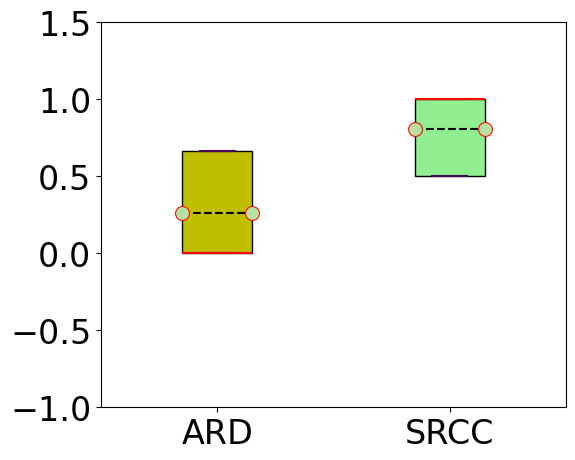

46场top1准确率： 0.8260869565217391


In [3]:
import pandas as pd
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import logging
import numpy as np
logging.getLogger('matplotlib').setLevel(logging.ERROR)
ARD_mean_ours = []
ARD_mean_baseline=[]
ARD_std_ours = []
ARD_std_baseline=[]
SRCC_mean_ours = []
SRCC_mean_baseline=[]
SRCC_std_ours = []
SRCC_std_baseline=[]
ACC_ours = []
ACC_baseline = []

#球员在所有胜场的shapley值排名平均
df = pd.read_csv('data/l33_mvp_values_v4.csv')
df['player'] = df['player'].astype('int64').map(player_dict)
ARD = []
SRCC = []
# R = []
count=0
num = 0
print(len(mvp_voting_dict))
for roomid in mvp_voting_dict.keys():
    num+=1
    # print(roomid)
    mvp_voting = mvp_voting_dict[roomid]
    topk = len(mvp_voting)
    #取出胜方球员
    result_df = df[df['room_id'] == roomid] 
    # print(len(result_df))
    result_df_win = result_df[result_df['result'] == 1]
    mvp_by_shap = result_df_win.groupby('player')['shap_order_team'].mean().sort_values(ascending=True)
    # print(len(mvp_by_shap),mvp_by_shap[:10])

    mvp_rank = mvp_by_shap.rank().sort_values()
    # print(mvp_rank)
    rank_mean_err = 0
    predicted_labels = []
    for i in range(topk):
        predicted_labels.append(mvp_rank[mvp_voting[i]]-1)
        rank_mean_err += abs(mvp_rank[mvp_voting[i]]-i-1)
    # print('rank_mean_err:', rank_mean_err/topk)
    actual_labels = list(range(topk))
    # print(actual_labels)
    # print(predicted_labels)
    # 计算Spearman相关系数
    correlation, p_value = spearmanr(actual_labels, predicted_labels)
    # print("Spearman相关系数:", correlation)
    # print("p值:", p_value)
    #预测第1名计算召回率=精度：
    if predicted_labels[0]==actual_labels[0]:
        count+=1
    # count = sum(1 for i in predicted_labels if i < topk)
    # print("Precision or Recall:", count/topk)
    
    ARD.append(rank_mean_err/topk)
    SRCC.append(correlation)
    # R.append(count/500)
# 计算平均值和标准差
mean_ARD = np.mean(ARD)
std_ARD = np.std(ARD)
print("ARD平均值：", mean_ARD)
print("标准差：", std_ARD)

mean_SRCC = np.mean(SRCC)
std_SRCC = np.std(SRCC)
print("SRCC平均值：", mean_SRCC)
print("标准差：", std_SRCC)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
plt.figure(figsize=(6, 5))  # 宽度为10英寸，高度为6英寸
bplot = plt.boxplot(
    x=[ARD, SRCC],         # 需要绘制的数据
    vert=True,          # 垂直排列箱线图
    widths=0.3,         # 箱形宽度
    labels=['ARD', 'SRCC'],      # 箱形图的标签
    patch_artist=True,  # 是否为箱子填充颜色，默认为False
    medianprops={       # 设置中位线属性
        'linestyle': '-', 'color': 'r', 'linewidth': 1.5
    },
    showmeans=True,     # 是否显示均值点，默认为False
    meanline=True,      # 是否显示均值线，默认为False
    meanprops={         # 设置均值点属性
        'marker': 'o', 'markersize': 10, 'markeredgewidth': 0.75, 'markerfacecolor': '#b7e1a1', 'markeredgecolor': 'r', 'color': 'k', 'linewidth': 1.5
    },
    showfliers=True,    # 是否显示异常值，默认为True
    flierprops={        # 设置异常点属性
        'marker': '^', 'markersize': 10, 'markeredgewidth': 0.75, 'markerfacecolor': '#ee5500', 'markeredgecolor': 'k'
    },
    whiskerprops={      # 设置须的线条属性
        'linestyle': '--', 'linewidth': 1.2, 'color': '#480656'
    },
    capprops={
        'linestyle': '-', 'linewidth': 1.5, 'color': '#480656'
    }
)
# 为箱形图填充颜色
colors = ['y', 'lightgreen']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    # 调整标签字体大小
plt.xticks(fontsize=24)  # 调整x轴标签字体大小
plt.yticks(fontsize=24)  # 调整y轴标签字体大小
plt.yticks([-1,-0.5, 0, 0.5, 1, 1.5])
# plt.title('Ours', fontsize=28)
plt.savefig('results/boxplot_ours.png')  
plt.show()
  
ACC = count/num
print(f"{num}场top1准确率：", ACC)
ARD_mean_ours.append(mean_ARD)
ARD_std_ours.append(std_ARD)
SRCC_mean_ours.append(mean_SRCC)
SRCC_std_ours.append(std_SRCC)
ACC_ours.append(ACC)
ARD_ours = ARD
SRCC_ours = SRCC


In [4]:
print(SRCC)

[0.5, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.5, 1.0, 0.5, 1.0, 0.5, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 1.0, 1.0, 1.0, 0.5, 0.5, 0.5, 1.0, 0.5, 1.0, 0.5]


45
ARD平均值： 0.2666666666666666
标准差： 0.3823255674241167
SRCC平均值： 0.7777777777777778
标准差： 0.35832256659104667


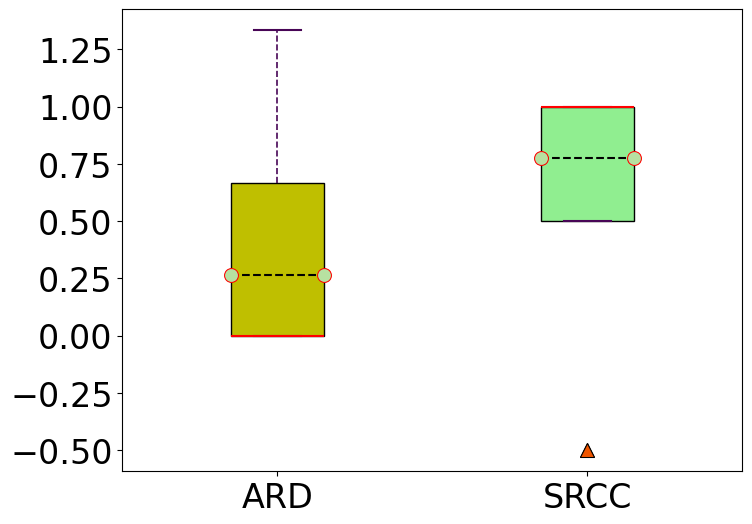

45场top1准确率： 0.8222222222222222


In [5]:
ARD = []
SRCC = []
# R = []
count=0
num = 0
print(len(mvp_voting_dict1))
for roomid in mvp_voting_dict1.keys():
    num+=1
    # print(roomid)
    mvp_voting = mvp_voting_dict1[roomid]
    topk = len(mvp_voting)
    #取出胜方球员
    result_df = df[df['room_id'] == roomid] 
    # print(len(result_df))
    result_df_win = result_df[result_df['result'] == 1]
    mvp_by_shap = result_df_win.groupby('player')['shap_order_team'].mean().sort_values(ascending=True)
    # print(len(mvp_by_shap),mvp_by_shap[:10])

    mvp_rank = mvp_by_shap.rank().sort_values()
    # print(mvp_rank)
    rank_mean_err = 0
    predicted_labels = []
    for i in range(topk):
        predicted_labels.append(mvp_rank[mvp_voting[i]]-1)
        rank_mean_err += abs(mvp_rank[mvp_voting[i]]-i-1)

    actual_labels = list(range(topk))

    correlation, p_value = spearmanr(actual_labels, predicted_labels)
    if predicted_labels[0]==actual_labels[0]:
        count+=1
  
    
    ARD.append(rank_mean_err/topk)
    SRCC.append(correlation)
    # R.append(count/500)
# 计算平均值和标准差
mean_ARD = np.mean(ARD)
std_ARD = np.std(ARD)
print("ARD平均值：", mean_ARD)
print("标准差：", std_ARD)

mean_SRCC = np.mean(SRCC)
std_SRCC = np.std(SRCC)
print("SRCC平均值：", mean_SRCC)
print("标准差：", std_SRCC)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
plt.figure(figsize=(8, 6))  # 宽度为10英寸，高度为6英寸
bplot = plt.boxplot(
    x=[ARD, SRCC],         # 需要绘制的数据
    vert=True,          # 垂直排列箱线图
    widths=0.3,         # 箱形宽度
    labels=['ARD', 'SRCC'],      # 箱形图的标签
    patch_artist=True,  # 是否为箱子填充颜色，默认为False
    medianprops={       # 设置中位线属性
        'linestyle': '-', 'color': 'r', 'linewidth': 1.5
    },
    showmeans=True,     # 是否显示均值点，默认为False
    meanline=True,      # 是否显示均值线，默认为False
    meanprops={         # 设置均值点属性
        'marker': 'o', 'markersize': 10, 'markeredgewidth': 0.75, 'markerfacecolor': '#b7e1a1', 'markeredgecolor': 'r', 'color': 'k', 'linewidth': 1.5
    },
    showfliers=True,    # 是否显示异常值，默认为True
    flierprops={        # 设置异常点属性
        'marker': '^', 'markersize': 10, 'markeredgewidth': 0.75, 'markerfacecolor': '#ee5500', 'markeredgecolor': 'k'
    },
    whiskerprops={      # 设置须的线条属性
        'linestyle': '--', 'linewidth': 1.2, 'color': '#480656'
    },
    capprops={
        'linestyle': '-', 'linewidth': 1.5, 'color': '#480656'
    }
)
# 为箱形图填充颜色
colors = ['y', 'lightgreen']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    # 调整标签字体大小
plt.xticks(fontsize=24)  # 调整x轴标签字体大小
plt.yticks(fontsize=24)  # 调整y轴标签字体大小
# plt.title('Ours', fontsize=28)
plt.savefig('results/boxplot_ours_test1.png')  
plt.show()
  

ACC = count/num
print(f"{num}场top1准确率：", ACC)
ARD_mean_ours.append(mean_ARD)
ARD_std_ours.append(std_ARD)
SRCC_mean_ours.append(mean_SRCC)
SRCC_std_ours.append(std_SRCC)
ACC_ours.append(ACC)

46
ARD平均值： 0.4057971014492754
标准差： 0.4499760781524645
SRCC平均值： 0.6195652173913043
标准差： 0.5232089802851625


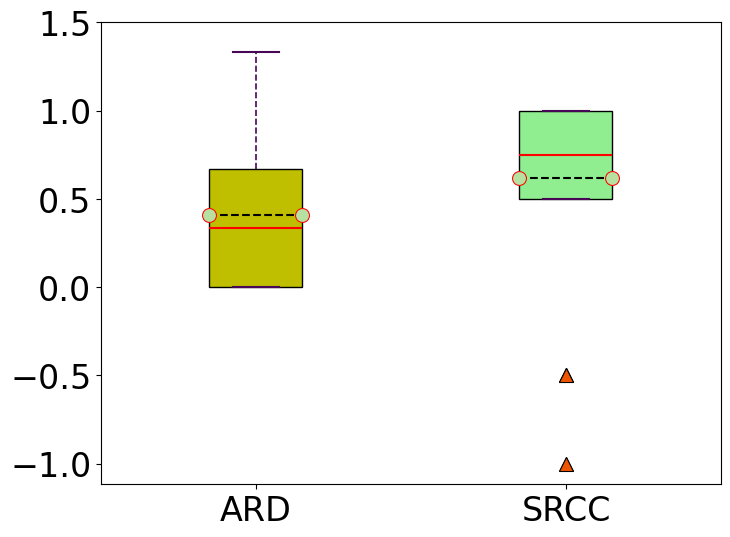

46场top1准确率： 0.7608695652173914


In [6]:
ARD = []
SRCC = []
# R = []
count=0
num = 0
print(len(mvp_voting_dict2))
for roomid in mvp_voting_dict2.keys():
    num+=1
    # print(roomid)
    mvp_voting = mvp_voting_dict2[roomid]
    topk = len(mvp_voting)
    #取出胜方球员
    result_df = df[df['room_id'] == roomid] 
    # print(len(result_df))
    result_df_win = result_df[result_df['result'] == 1]
    mvp_by_shap = result_df_win.groupby('player')['shap_order_team'].mean().sort_values(ascending=True)
    # print(len(mvp_by_shap),mvp_by_shap[:10])

    mvp_rank = mvp_by_shap.rank().sort_values()
    # print(mvp_rank)
    rank_mean_err = 0
    predicted_labels = []
    for i in range(topk):
        predicted_labels.append(mvp_rank[mvp_voting[i]]-1)
        rank_mean_err += abs(mvp_rank[mvp_voting[i]]-i-1)
    # print('rank_mean_err:', rank_mean_err/topk)
    actual_labels = list(range(topk))
    # print(actual_labels)
    # print(predicted_labels)
    # 计算Spearman相关系数
    correlation, p_value = spearmanr(actual_labels, predicted_labels)
    # print("Spearman相关系数:", correlation)
    # print("p值:", p_value)
    #预测第1名计算召回率=精度：
    if predicted_labels[0]==actual_labels[0]:
        count+=1
    # count = sum(1 for i in predicted_labels if i < topk)
    # print("Precision or Recall:", count/topk)
    
    ARD.append(rank_mean_err/topk)
    SRCC.append(correlation)
    # R.append(count/500)
# 计算平均值和标准差
mean_ARD = np.mean(ARD)
std_ARD = np.std(ARD)
print("ARD平均值：", mean_ARD)
print("标准差：", std_ARD)

mean_SRCC = np.mean(SRCC)
std_SRCC = np.std(SRCC)
print("SRCC平均值：", mean_SRCC)
print("标准差：", std_SRCC)

plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
plt.figure(figsize=(8, 6))  # 宽度为10英寸，高度为6英寸
bplot = plt.boxplot(
    x=[ARD, SRCC],         # 需要绘制的数据
    vert=True,          # 垂直排列箱线图
    widths=0.3,         # 箱形宽度
    labels=['ARD', 'SRCC'],      # 箱形图的标签
    patch_artist=True,  # 是否为箱子填充颜色，默认为False
    medianprops={       # 设置中位线属性
        'linestyle': '-', 'color': 'r', 'linewidth': 1.5
    },
    showmeans=True,     # 是否显示均值点，默认为False
    meanline=True,      # 是否显示均值线，默认为False
    meanprops={         # 设置均值点属性
        'marker': 'o', 'markersize': 10, 'markeredgewidth': 0.75, 'markerfacecolor': '#b7e1a1', 'markeredgecolor': 'r', 'color': 'k', 'linewidth': 1.5
    },
    showfliers=True,    # 是否显示异常值，默认为True
    flierprops={        # 设置异常点属性
        'marker': '^', 'markersize': 10, 'markeredgewidth': 0.75, 'markerfacecolor': '#ee5500', 'markeredgecolor': 'k'
    },
    whiskerprops={      # 设置须的线条属性
        'linestyle': '--', 'linewidth': 1.2, 'color': '#480656'
    },
    capprops={
        'linestyle': '-', 'linewidth': 1.5, 'color': '#480656'
    }
)
# 为箱形图填充颜色
colors = ['y', 'lightgreen']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    # 调整标签字体大小
plt.xticks(fontsize=24)  # 调整x轴标签字体大小
plt.yticks(fontsize=24)  # 调整y轴标签字体大小
plt.yticks([-1, -0.5, 0, 0.5, 1, 1.5])
# plt.title('Ours', fontsize=28)
plt.savefig('results/boxplot_ours_test2.png')  
plt.show()
  
ACC = count/num
print(f"{num}场top1准确率：", ACC)
ARD_mean_ours.append(mean_ARD)
ARD_std_ours.append(std_ARD)
SRCC_mean_ours.append(mean_SRCC)
SRCC_std_ours.append(std_SRCC)
ACC_ours.append(ACC)

# baseline2

3000
ARD平均值： 0.42028985507246375
标准差： 0.4419695849848379
SRCC平均值： 0.616652726169227
标准差： 0.5109244201779236


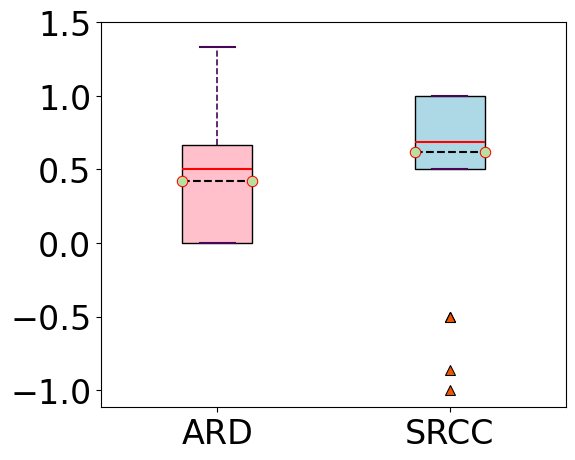

46场top1准确率： 0.5434782608695652


In [7]:
# 直接用游戏mvp结算数据
import numpy as np
from sklearn.metrics import ndcg_score, average_precision_score
import pandas as pd
from scipy.stats import spearmanr

df = pd.read_csv("data/dianfengsai_home_result_20240715_500_goalin.csv")
print(len(df))

ARD = []
SRCC = []
# R = []
count = 0
num = 0
for roomid in mvp_voting_dict.keys():
    num+=1
    # print(roomid)
    mvp_voting = mvp_voting_dict[roomid]
    topk = len(mvp_voting)
    result_df = df[df['room_id'] == roomid] 
    if len(result_df)!=6:
        break
    result_df = result_df.copy()
    result_df.loc[:,'player'] = result_df['role_player_id'].astype('int64').map(player_dict)
    result_df_win = result_df[result_df['result'] == 1]
    mvp_by_shap = result_df_win.groupby('player')['mvppoint'].mean().sort_values(ascending=False)
    # print(mvp_by_shap[:10])
    mvp_rank = mvp_by_shap.rank(ascending=False)
    rank_mean_err = 0
    predicted_labels = []
    for i in range(topk):
        predicted_labels.append(mvp_rank[mvp_voting[i]]-1)
        rank_mean_err += abs(mvp_rank[mvp_voting[i]]-i-1)
    # print('rank_mean_err:', rank_mean_err/topk)
    actual_labels = list(range(topk))
    # print(actual_labels)
    # print(predicted_labels)
    # 计算Spearman相关系数
    correlation, p_value = spearmanr(actual_labels, predicted_labels)
    # print("Spearman相关系数:", correlation)
    # print("p值:", p_value)
    #前13名计算召回率=精度：.
    # count = sum(1 for i in predicted_labels if i < topk)
    # print("Precision or recall:", count/topk)
    if predicted_labels[0]==actual_labels[0]:
        count+=1
    
    ARD.append(rank_mean_err/topk)
    SRCC.append(correlation)
    # R.append(count/topk)
    
# 计算平均值和标准差
mean_ARD = np.mean(ARD)
std_ARD = np.std(ARD)
# 绘制箱线图
# plt.boxplot(ARD)
# plt.title('ARD Boxplot')
# plt.savefig('results/ARD_boxplot_baseline.png')  
# plt.show()
print("ARD平均值：", mean_ARD)
print("标准差：", std_ARD)

mean_SRCC = np.mean(SRCC)
std_SRCC = np.std(SRCC)
# plt.boxplot(SRCC)
# plt.title('SRCC Boxplot')
# plt.savefig('results/SRCC_boxplot_baseline.png')  
# plt.show()
print("SRCC平均值：", mean_SRCC)
print("标准差：", std_SRCC)

plt.figure(figsize=(6, 5))  # 宽度为10英寸，高度为6英寸
bplot = plt.boxplot(
    x=[ARD, SRCC],         # 需要绘制的数据
    vert=True,          # 垂直排列箱线图
    widths=0.3,         # 箱形宽度
    labels=['ARD', 'SRCC'],      # 箱形图的标签
    patch_artist=True,  # 是否为箱子填充颜色，默认为False
    medianprops={       # 设置中位线属性
        'linestyle': '-', 'color': 'r', 'linewidth': 1.5
    },
    showmeans=True,     # 是否显示均值点，默认为False
    meanline=True,      # 是否显示均值线，默认为False
    meanprops={         # 设置均值点属性
        'marker': 'o', 'markersize': 7.5, 'markeredgewidth': 0.75, 'markerfacecolor': '#b7e1a1', 'markeredgecolor': 'r', 'color': 'k', 'linewidth': 1.5
    },
    showfliers=True,    # 是否显示异常值，默认为True
    flierprops={        # 设置异常点属性
        'marker': '^', 'markersize': 6.75, 'markeredgewidth': 0.75, 'markerfacecolor': '#ee5500', 'markeredgecolor': 'k'
    },
    whiskerprops={      # 设置须的线条属性
        'linestyle': '--', 'linewidth': 1.2, 'color': '#480656'
    },
    capprops={
        'linestyle': '-', 'linewidth': 1.5, 'color': '#480656'
    }
)
# 为箱形图填充颜色
colors = ['pink', 'lightblue']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
plt.xticks(fontsize=24)  # 调整x轴标签字体大小
plt.yticks(fontsize=24)  # 调整y轴标签字体大小
plt.yticks([-1, -0.5, 0, 0.5, 1, 1.5])
# plt.title('Baseline', fontsize=28)
plt.savefig('results/boxplot_baseline.png')  
plt.show()
  

ACC = count/num
print(f"{num}场top1准确率：", ACC)
ARD_mean_baseline.append(mean_ARD)
ARD_std_baseline.append(std_ARD)
SRCC_mean_baseline.append(mean_SRCC)
SRCC_std_baseline.append(std_SRCC)
ACC_baseline.append(ACC)
ARD_baseline = ARD
SRCC_baseline = SRCC

ARD平均值： 0.6148148148148148
标准差： 0.432937457665258
SRCC平均值： 0.4414672311952098
标准差： 0.5159629782183469


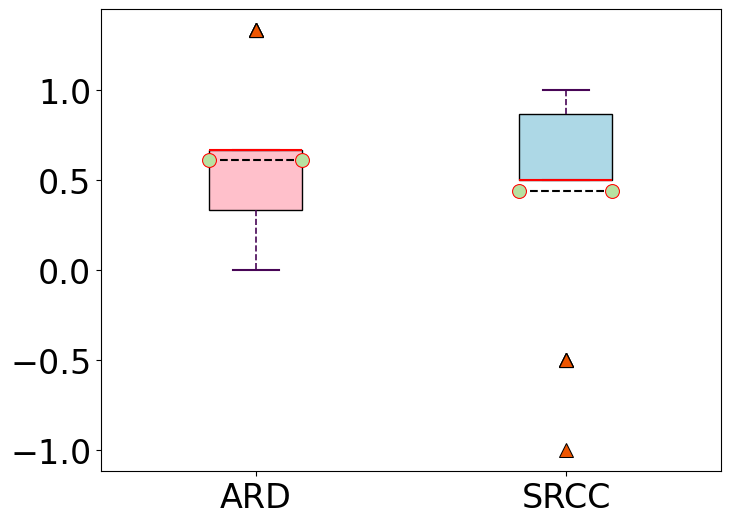

45场top1准确率： 0.4888888888888889


In [8]:
ARD = []
SRCC = []
# R = []
count = 0
num = 0
for roomid in mvp_voting_dict1.keys():
    num+=1
    # print(roomid)
    mvp_voting = mvp_voting_dict1[roomid]
    topk = len(mvp_voting)
    result_df = df[df['room_id'] == roomid] 
    if len(result_df)!=6:
        break
    result_df = result_df.copy()
    result_df.loc[:,'player'] = result_df['role_player_id'].astype('int64').map(player_dict)
    result_df_win = result_df[result_df['result'] == 1]
    mvp_by_shap = result_df_win.groupby('player')['mvppoint'].mean().sort_values(ascending=False)
    # print(mvp_by_shap[:10])
    mvp_rank = mvp_by_shap.rank(ascending=False)
    rank_mean_err = 0
    predicted_labels = []
    for i in range(topk):
        predicted_labels.append(mvp_rank[mvp_voting[i]]-1)
        rank_mean_err += abs(mvp_rank[mvp_voting[i]]-i-1)
    # print('rank_mean_err:', rank_mean_err/topk)
    actual_labels = list(range(topk))
    # print(actual_labels)
    # print(predicted_labels)
    # 计算Spearman相关系数
    correlation, p_value = spearmanr(actual_labels, predicted_labels)
    # print("Spearman相关系数:", correlation)
    # print("p值:", p_value)
    #前13名计算召回率=精度：.
    # count = sum(1 for i in predicted_labels if i < topk)
    # print("Precision or recall:", count/topk)
    if predicted_labels[0]==actual_labels[0]:
        count+=1
    
    ARD.append(rank_mean_err/topk)
    SRCC.append(correlation)
    # R.append(count/topk)
    
# 计算平均值和标准差
mean_ARD = np.mean(ARD)
std_ARD = np.std(ARD)
print("ARD平均值：", mean_ARD)
print("标准差：", std_ARD)

mean_SRCC = np.mean(SRCC)
std_SRCC = np.std(SRCC)
print("SRCC平均值：", mean_SRCC)
print("标准差：", std_SRCC)
plt.figure(figsize=(8, 6))  # 宽度为10英寸，高度为6英寸
bplot = plt.boxplot(
    x=[ARD, SRCC],         # 需要绘制的数据
    vert=True,          # 垂直排列箱线图
    widths=0.3,         # 箱形宽度
    labels=['ARD', 'SRCC'],      # 箱形图的标签
    patch_artist=True,  # 是否为箱子填充颜色，默认为False
    medianprops={       # 设置中位线属性
        'linestyle': '-', 'color': 'r', 'linewidth': 1.5
    },
    showmeans=True,     # 是否显示均值点，默认为False
    meanline=True,      # 是否显示均值线，默认为False
    meanprops={         # 设置均值点属性
        'marker': 'o', 'markersize': 10, 'markeredgewidth': 0.75, 'markerfacecolor': '#b7e1a1', 'markeredgecolor': 'r', 'color': 'k', 'linewidth': 1.5
    },
    showfliers=True,    # 是否显示异常值，默认为True
    flierprops={        # 设置异常点属性
        'marker': '^', 'markersize': 10, 'markeredgewidth': 0.75, 'markerfacecolor': '#ee5500', 'markeredgecolor': 'k'
    },
    whiskerprops={      # 设置须的线条属性
        'linestyle': '--', 'linewidth': 1.2, 'color': '#480656'
    },
    capprops={
        'linestyle': '-', 'linewidth': 1.5, 'color': '#480656'
    }
)
# 为箱形图填充颜色
colors = ['pink', 'lightblue']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)   
plt.xticks(fontsize=24)  # 调整x轴标签字体大小
plt.yticks(fontsize=24)  # 调整y轴标签字体大小
# plt.title('Baseline', fontsize=28)
plt.savefig('results/boxplot_baseline_rest1.png')  
plt.show()
  

ACC = count/num
print(f"{num}场top1准确率：", ACC)
ARD_mean_baseline.append(mean_ARD)
ARD_std_baseline.append(std_ARD)
SRCC_mean_baseline.append(mean_SRCC)
SRCC_std_baseline.append(std_SRCC)
ACC_baseline.append(ACC)

ARD平均值： 0.5217391304347827
标准差： 0.4150093061819232
SRCC平均值： 0.5543478260869565
标准差： 0.4327397660303126


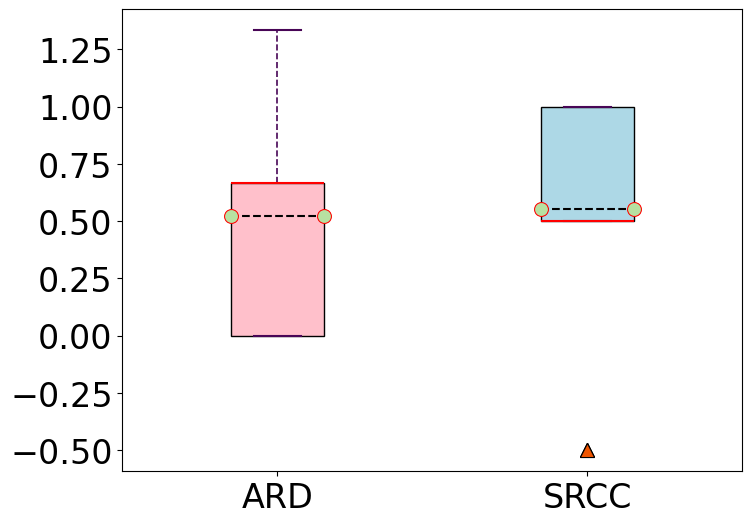

46场top1准确率： 0.43478260869565216


In [9]:
ARD = []
SRCC = []
# R = []
count = 0
num = 0
for roomid in mvp_voting_dict2.keys():
    num+=1
    # print(roomid)
    mvp_voting = mvp_voting_dict2[roomid]
    topk = len(mvp_voting)
    result_df = df[df['room_id'] == roomid] 
    if len(result_df)!=6:
        break
    result_df = result_df.copy()
    result_df.loc[:,'player'] = result_df['role_player_id'].astype('int64').map(player_dict)
    result_df_win = result_df[result_df['result'] == 1]
    mvp_by_shap = result_df_win.groupby('player')['mvppoint'].mean().sort_values(ascending=False)
    # print(mvp_by_shap[:10])
    mvp_rank = mvp_by_shap.rank(ascending=False)
    rank_mean_err = 0
    predicted_labels = []
    for i in range(topk):
        predicted_labels.append(mvp_rank[mvp_voting[i]]-1)
        rank_mean_err += abs(mvp_rank[mvp_voting[i]]-i-1)
    # print('rank_mean_err:', rank_mean_err/topk)
    actual_labels = list(range(topk))
    # print(actual_labels)
    # print(predicted_labels)
    # 计算Spearman相关系数
    correlation, p_value = spearmanr(actual_labels, predicted_labels)
    # print("Spearman相关系数:", correlation)
    # print("p值:", p_value)
    #前13名计算召回率=精度：.
    # count = sum(1 for i in predicted_labels if i < topk)
    # print("Precision or recall:", count/topk)
    if predicted_labels[0]==actual_labels[0]:
        count+=1
    
    ARD.append(rank_mean_err/topk)
    SRCC.append(correlation)
    # R.append(count/topk)
    
# 计算平均值和标准差
mean_ARD = np.mean(ARD)
std_ARD = np.std(ARD)
print("ARD平均值：", mean_ARD)
print("标准差：", std_ARD)

mean_SRCC = np.mean(SRCC)
std_SRCC = np.std(SRCC)
print("SRCC平均值：", mean_SRCC)
print("标准差：", std_SRCC)
plt.figure(figsize=(8, 6))  # 宽度为10英寸，高度为6英寸
bplot = plt.boxplot(
    x=[ARD, SRCC],         # 需要绘制的数据
    vert=True,          # 垂直排列箱线图
    widths=0.3,         # 箱形宽度
    labels=['ARD', 'SRCC'],      # 箱形图的标签
    patch_artist=True,  # 是否为箱子填充颜色，默认为False
    medianprops={       # 设置中位线属性
        'linestyle': '-', 'color': 'r', 'linewidth': 1.5
    },
    showmeans=True,     # 是否显示均值点，默认为False
    meanline=True,      # 是否显示均值线，默认为False
    meanprops={         # 设置均值点属性
        'marker': 'o', 'markersize': 10, 'markeredgewidth': 0.75, 'markerfacecolor': '#b7e1a1', 'markeredgecolor': 'r', 'color': 'k', 'linewidth': 1.5
    },
    showfliers=True,    # 是否显示异常值，默认为True
    flierprops={        # 设置异常点属性
        'marker': '^', 'markersize': 10, 'markeredgewidth': 0.75, 'markerfacecolor': '#ee5500', 'markeredgecolor': 'k'
    },
    whiskerprops={      # 设置须的线条属性
        'linestyle': '--', 'linewidth': 1.2, 'color': '#480656'
    },
    capprops={
        'linestyle': '-', 'linewidth': 1.5, 'color': '#480656'
    }
)
# 为箱形图填充颜色
colors = ['pink', 'lightblue']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)   
plt.xticks(fontsize=24)  # 调整x轴标签字体大小
plt.yticks(fontsize=24)  # 调整y轴标签字体大小
# plt.title('Baseline', fontsize=28)
plt.savefig('results/boxplot_baseline_rest2.png')  
plt.show()
  

ACC = count/num
print(f"{num}场top1准确率：", ACC)
ARD_mean_baseline.append(mean_ARD)
ARD_std_baseline.append(std_ARD)
SRCC_mean_baseline.append(mean_SRCC)
SRCC_std_baseline.append(std_SRCC)
ACC_baseline.append(ACC)

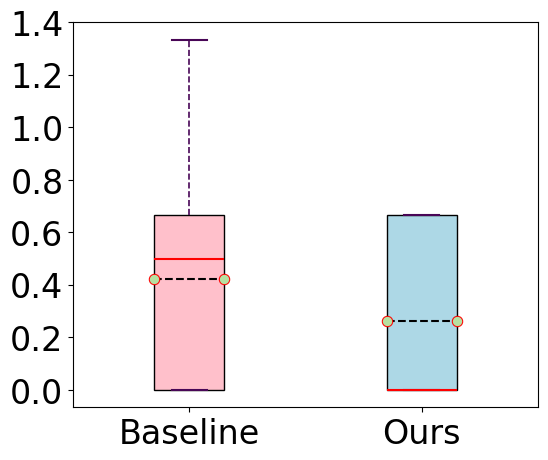

In [10]:
plt.figure(figsize=(6, 5))  # 宽度为10英寸，高度为6英寸
bplot = plt.boxplot(
    x=[ ARD_baseline, ARD_ours],         # 需要绘制的数据
    vert=True,          # 垂直排列箱线图
    widths=0.3,         # 箱形宽度
    labels=[ 'Baseline', 'Ours'],      # 箱形图的标签
    patch_artist=True,  # 是否为箱子填充颜色，默认为False
    medianprops={       # 设置中位线属性
        'linestyle': '-', 'color': 'r', 'linewidth': 1.5
    },
    showmeans=True,     # 是否显示均值点，默认为False
    meanline=True,      # 是否显示均值线，默认为False
    meanprops={         # 设置均值点属性
        'marker': 'o', 'markersize': 7.5, 'markeredgewidth': 0.75, 'markerfacecolor': '#b7e1a1', 'markeredgecolor': 'r', 'color': 'k', 'linewidth': 1.5
    },
    showfliers=True,    # 是否显示异常值，默认为True
    flierprops={        # 设置异常点属性
        'marker': '^', 'markersize': 6.75, 'markeredgewidth': 0.75, 'markerfacecolor': '#ee5500', 'markeredgecolor': 'k'
    },
    whiskerprops={      # 设置须的线条属性
        'linestyle': '--', 'linewidth': 1.2, 'color': '#480656'
    },
    capprops={
        'linestyle': '-', 'linewidth': 1.5, 'color': '#480656'
    }
)

# 为箱形图填充颜色
colors = ['pink', 'lightblue']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
plt.xticks(fontsize=24)  # 调整x轴标签字体大小
plt.yticks(fontsize=24)  # 调整y轴标签字体大小
# plt.yticks([-1, -0.5, 0, 0.5, 1, 1.5])
# plt.title('Baseline', fontsize=28)
plt.savefig('results/boxplot_ARD.png')  
plt.show()
  

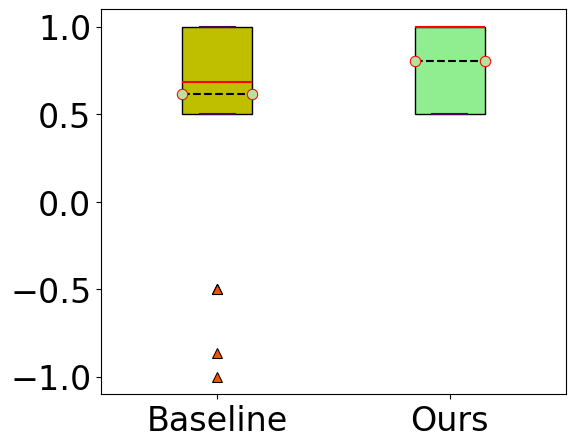

In [15]:

plt.figure(figsize=(6, 5))  # 宽度为10英寸，高度为6英寸
bplot = plt.boxplot(
    x=[ SRCC_baseline, SRCC_ours],         # 需要绘制的数据
    vert=True,          # 垂直排列箱线图
    widths=0.3,         # 箱形宽度
    labels=[ 'Baseline', 'Ours'],      # 箱形图的标签
    patch_artist=True,  # 是否为箱子填充颜色，默认为False
    medianprops={       # 设置中位线属性
        'linestyle': '-', 'color': 'r', 'linewidth': 1.5
    },
    showmeans=True,     # 是否显示均值点，默认为False
    meanline=True,      # 是否显示均值线，默认为False
    meanprops={         # 设置均值点属性
        'marker': 'o', 'markersize': 7.5, 'markeredgewidth': 0.75, 'markerfacecolor': '#b7e1a1', 'markeredgecolor': 'r', 'color': 'k', 'linewidth': 1.5
    },
    showfliers=True,    # 是否显示异常值，默认为True
    flierprops={        # 设置异常点属性
        'marker': '^', 'markersize': 6.75, 'markeredgewidth': 0.75, 'markerfacecolor': '#ee5500', 'markeredgecolor': 'k'
    },
    whiskerprops={      # 设置须的线条属性
        'linestyle': '--', 'linewidth': 1.2, 'color': '#480656'
    },
    capprops={
        'linestyle': '-', 'linewidth': 1.5, 'color': '#480656'
    }
)
# 为箱形图填充颜色
colors = ['y', 'lightgreen']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
plt.xticks(fontsize=24)  # 调整x轴标签字体大小
plt.yticks(fontsize=24)  # 调整y轴标签字体大小
plt.yticks([-1, -0.5, 0, 0.5, 1])
# plt.title('Baseline', fontsize=28)
plt.savefig('results/boxplot_SRCC.png')  
plt.show()

# 绘制随置信度变化指标的均值方差图

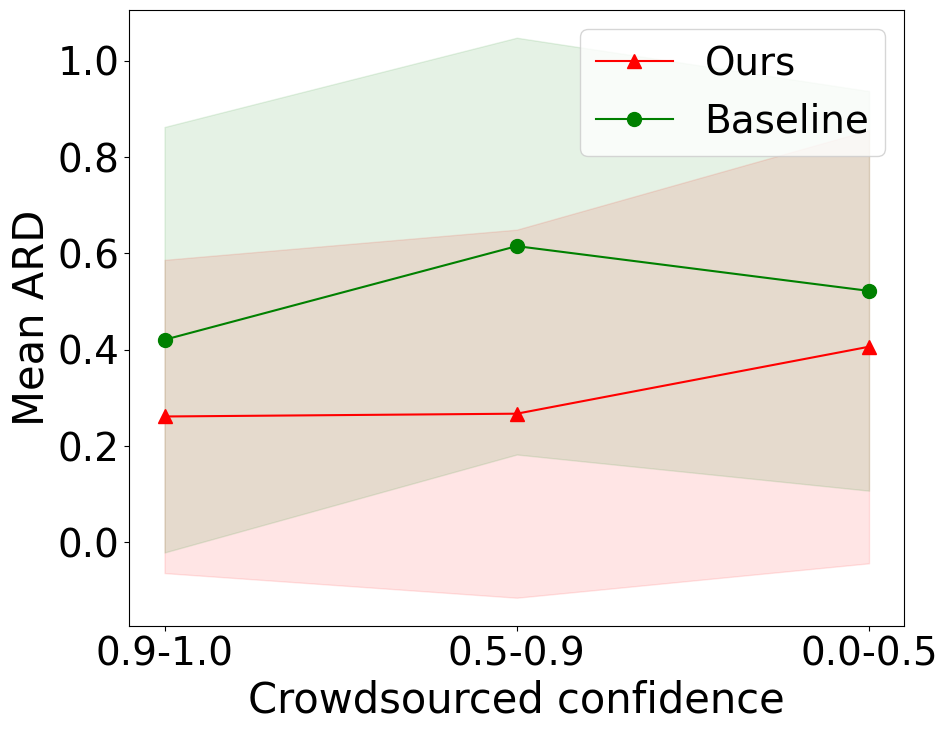

<Figure size 1000x800 with 0 Axes>

In [12]:
plt.rcParams['figure.figsize'] = 10,8
plt.rcParams['font.size'] = 28
plt.xlabel('Crowdsourced confidence', fontsize=30)
plt.ylabel('Mean ARD', fontsize=30)

xlabel = ['0.9-1.0','0.5-0.9','0.0-0.5']

# 绘制均值误差图
plt.plot(xlabel , ARD_mean_ours, '^-', color='r', markersize=10)  # 绘制均值线
plt.plot(xlabel, ARD_mean_baseline, 'o-', color='g', markersize=10)  # 绘制均值线

plt.fill_between(xlabel, np.array(ARD_mean_ours)-np.array(ARD_std_ours), np.array(ARD_mean_ours)+np.array(ARD_std_ours), color='r', alpha=0.1)  # 填充误差范围的阴影部分
plt.fill_between(xlabel, np.array(ARD_mean_baseline) - np.array(ARD_std_baseline), np.array(ARD_mean_baseline) + np.array(ARD_std_baseline), color='g', alpha=0.1)  # 填充误差范围的阴影部分

legends = ['Ours', 'Baseline']
plt.legend(legends)
# plt.title('Mean Error Plot with Shaded Error Area')
plt.savefig('results/compare_ARD_mean_error_plot.png', bbox_inches='tight')  # 保存为 PNG 格式
# plt.savefig('results/compare_ARD_mean_error_plot.pdf', bbox_inches='tight')
# plt.xticks(fontsize=30)  # 调整x轴标签字体大小
# plt.yticks(fontsize=30)  # 调整y轴标签字体大小
plt.show()
plt.clf()

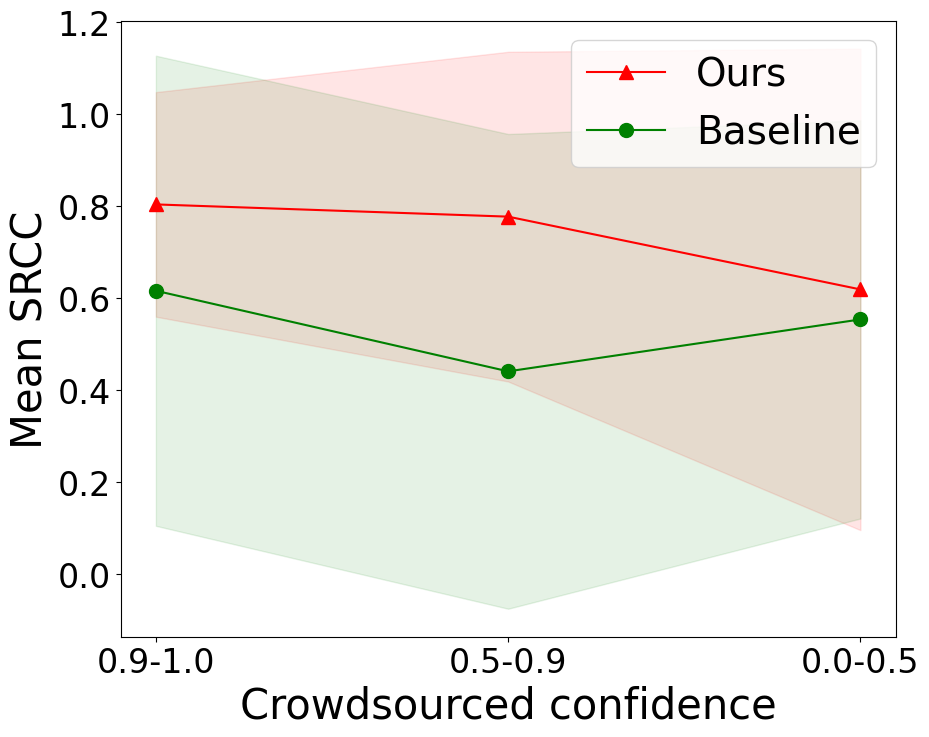

<Figure size 1000x800 with 0 Axes>

In [13]:
plt.rcParams['figure.figsize'] = 10,8
plt.rcParams['font.size'] = 28
plt.xlabel('Crowdsourced confidence', fontsize=30)
plt.ylabel('Mean SRCC', fontsize=30)

xlabel = ['0.9-1.0','0.5-0.9','0.0-0.5']

# 绘制均值误差图
plt.plot(xlabel , SRCC_mean_ours, '^-', color='r', markersize=10)  # 绘制均值线
plt.plot(xlabel, SRCC_mean_baseline, 'o-', color='g', markersize=10)  # 绘制均值线

plt.fill_between(xlabel, np.array(SRCC_mean_ours)-np.array(SRCC_std_ours), np.array(SRCC_mean_ours)+np.array(SRCC_std_ours), color='r', alpha=0.1)  # 填充误差范围的阴影部分
plt.fill_between(xlabel, np.array(SRCC_mean_baseline) - np.array(SRCC_std_baseline), np.array(SRCC_mean_baseline) + np.array(SRCC_std_baseline), color='g', alpha=0.1)  # 填充误差范围的阴影部分

legends = ['Ours', 'Baseline']
plt.legend(legends)
# plt.title('Mean Error Plot with Shaded Error Area')
plt.savefig('results/compare_SRCC_mean_error_plot.png', bbox_inches='tight')  # 保存为 PNG 格式
# plt.savefig('results/compare_SRCC_mean_error_plot.pdf', bbox_inches='tight')
plt.xticks(fontsize=24)  # 调整x轴标签字体大小
plt.yticks(fontsize=24)  # 调整y轴标签字体大小
plt.show()
plt.clf()

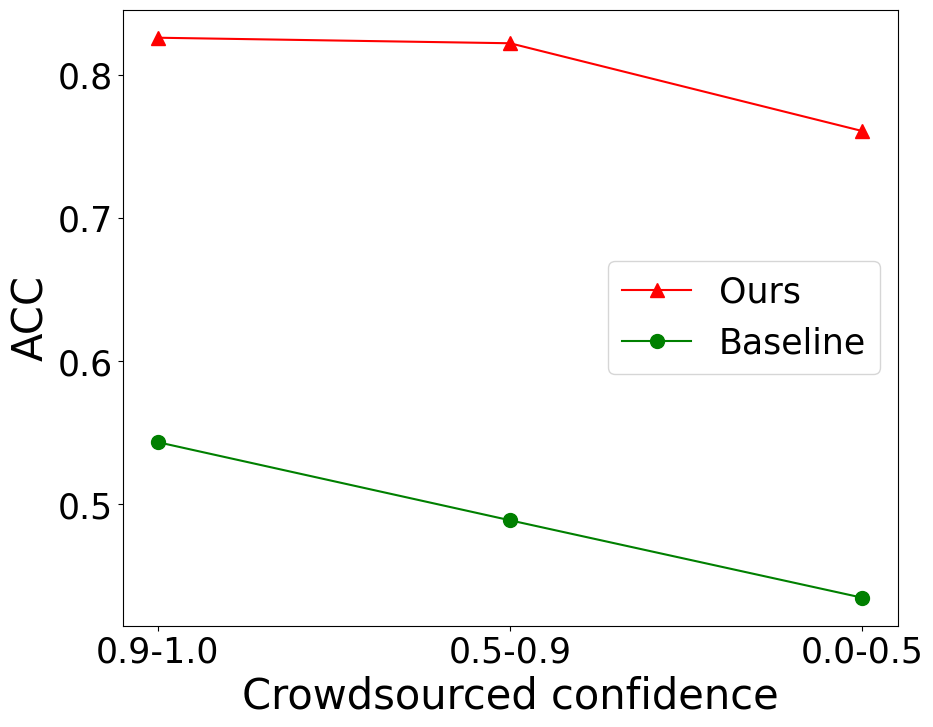

ACC_baseline: [0.5434782608695652, 0.4888888888888889, 0.43478260869565216]
ACC_ours: [0.8260869565217391, 0.8222222222222222, 0.7608695652173914]


<Figure size 1000x800 with 0 Axes>

In [14]:
plt.rcParams['figure.figsize'] = 10,8
plt.rcParams['font.size'] = 25
plt.xlabel('Crowdsourced confidence', fontsize=30)
plt.ylabel('ACC', fontsize=30)

xlabel = ['0.9-1.0','0.5-0.9','0.0-0.5']

# 绘制均值误差图
plt.plot(xlabel , ACC_ours, '^-', color='r', markersize=10)  # 绘制均值线
plt.plot(xlabel, ACC_baseline, 'o-', color='g', markersize=10)  # 绘制均值线

# plt.fill_between(xlabel, np.array(ACC_mean_ours)-np.array(ACC_std_ours), np.array(ACC_mean_ours)+np.array(ACC_std_ours), color='r', alpha=0.1)  # 填充误差范围的阴影部分
# plt.fill_between(xlabel, np.array(ACC_mean_baseline) - np.array(ACC_std_baseline), np.array(ACC_mean_baseline) + np.array(ACC_std_baseline), color='g', alpha=0.1)  # 填充误差范围的阴影部分

legends = ['Ours', 'Baseline']
plt.legend(legends)
# plt.title('Mean Error Plot with Shaded Error Area')
plt.savefig('results/compare_ACC_plot.png', bbox_inches='tight')  # 保存为 PNG 格式
# plt.savefig('results/compare_ACC_mean_error_plot.pdf', bbox_inches='tight')
plt.show()
plt.clf()
print('ACC_baseline:',ACC_baseline)
print('ACC_ours:',ACC_ours)